In [2]:
#Imports

import numpy as np
import os
import shutil
import openpyxl as oxl
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from copy import deepcopy

from datetime import datetime

from collections import deque

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker
from PIL import Image
import cv2

import json
import xml.etree.ElementTree as ET
#this is to automatically parse xml into dict
import xmltodict

import collections

import math

# This is needed if the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')

#imports from object-detection module
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

# This is needed to display the images.
%matplotlib inline

## Image 2 Image Registration

### Method Definitions

In [61]:
def displayXmlPointsOnImage(img, xmlRoot):
    img_name = xmlRoot.find('img_name').text[:-5]
    toothTips = xmlRoot.find('toothTip')
    lipShrouds = xmlRoot.find('lipShroud')
    liftingEyes = xmlRoot.find('liftingEye')
    castLips = xmlRoot.find('castLip')
    bucketLandmarks = xmlRoot.find('bucketLandmark')
    
    displayPointOnImage(img, toothTips, 1)
    displayPointOnImage(img, lipShrouds, 2)
    displayPointOnImage(img, liftingEyes, 3)
    displayPointOnImage(img, castLips, 4)
    displayPointOnImage(img, bucketLandmarks, 5)

In [62]:
def displayPointOnImage(img, points, lmNb):
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    height, width, dim=img.shape
    
    for point in points:
        xcor = int(float(point.get('x')) * width)
        ycor = int(float(point.get('y') )* height)
        
        cv2.circle(img, (xcor, ycor), 5, colors[lmNb-1], -1)

In [63]:
def displayPointsSetOnImage(img, points, color=0):
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]
    for point in points[0]:
        xcor = point[0]
        ycor = point[1]
        
        cv2.circle(img, (xcor, ycor), 5, colors[color], -1)

In [64]:
def getPointsSet(img, xmlRoot):
    points = np.zeros((1, 30, 2), np.int32)
    counter = 0
    
    height, width, dim=img.shape
    
    toothTips = xmlRoot.find('toothTip')
    lipShrouds = xmlRoot.find('lipShroud')
    liftingEyes = xmlRoot.find('liftingEye')
    castLips = xmlRoot.find('castLip')
    bucketLandmarks = xmlRoot.find('bucketLandmark')
    
    
    for pp in toothTips:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
    
    for pp in lipShrouds:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for pp in liftingEyes:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for pp in castLips:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for pp in bucketLandmarks:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    return points

In [65]:
def getPointsSetMiddleTeeth(img, xmlRoot):
    points = np.zeros((1, 20, 2), np.int32)
    counter = 0
    
    height, width, dim=img.shape
    
    toothTips = xmlRoot.find('toothTip')
    lipShrouds = xmlRoot.find('lipShroud')
    liftingEyes = xmlRoot.find('liftingEye')
    castLips = xmlRoot.find('castLip')
    bucketLandmarks = xmlRoot.find('bucketLandmark')
    
    for i in range(len(toothTips)-2):
        pp = toothTips[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for i in range(len(lipShrouds)-2):
        pp = lipShrouds[i+1] 

        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        

    for i in range(len(liftingEyes)-2):
        pp = liftingEyes[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for i in range(len(castLips)-2):
        pp = castLips[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    for i in range(len(bucketLandmarks)-2):
        pp = bucketLandmarks[i+1] 
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
        
        
    return points

In [66]:
def getPointsSetSpecific(img, xmlRoot, keyword):
    height, width, dim=img.shape
    
    landmarks = xmlRoot.find(keyword)
    points = np.zeros((1, len(landmarks), 2), np.int32)
    counter = 0
    
    for pp in landmarks:
        xcor = int(float(pp.get('x')) * width)
        ycor = int(float(pp.get('y') )* height)
        points[0, counter, 0] = xcor
        points[0, counter, 1] = ycor
        counter+=1
  
    return points

In [67]:
def getRegError(registeredPoints, targetPointSet):
    totalError = 0
    counter = 0
    
    for i in range(len(targetPointSet[0])):
        totalError += getDist(registeredPoints[0][i], targetPointSet[0][i])
        counter+=1
        
    return totalError/counter

In [68]:
def getDist(point1, point2):
    #return abs(point2[0] - point1[0]) + abs(point2[1] - point1[1]) 
    #return math.sqrt(math.pow((point2[0] - point1[0]), 2) + math.pow((point2[1] - point1[1]), 2) )
    return math.sqrt(math.pow((point2[1] - point1[1]), 2) )

### Registering 2 frames

In [ ]:
#Peform FULL image2image registeration on two reference frames 

imagesPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/images/'
labelsPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/labels/'

file1 = '1_20161116-074000_0001n0_9767'
file2 = '1_20161116-152500_0001n0_783'

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')

root1 = ET.parse(labelsPathDir + file1 + '_landmarkCoords.xml').getroot()
root2 = ET.parse(labelsPathDir + file2 + '_landmarkCoords.xml').getroot()

# Display loaded points on images 
displayXmlPointsOnImage(img1, root1)
displayXmlPointsOnImage(img2, root2)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()





landmarksSet1 = getPointsSet(img1, root1)
landmarksSet2 = getPointsSet(img2, root2)




# Display loaded landmarks on images 
print('landmarksSet1')
print(landmarksSet1[0,1:3,:])
print('landmarksSet2')
print(landmarksSet2[0,1:3,:])

displayPointsSetOnImage(img1, landmarksSet1)
displayPointsSetOnImage(img2, landmarksSet2)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')




# Learn different transformations
transformationRegid5D = cv2.estimateRigidTransform(landmarksSet2, landmarksSet1, False)
transformationRegid6D = cv2.estimateRigidTransform(landmarksSet2, landmarksSet1, True)
transformationHomo, mask = cv2.findHomography(landmarksSet2, landmarksSet1, cv2.RANSAC)




# warp image using learned transformation

transImageRegid5D = cv2.warpAffine(img2, transformationRegid5D,(720, 480))
transImageRegid6D = cv2.warpAffine(img2, transformationRegid6D,(720, 480))
transImageHomo = cv2.warpPerspective(img2, transformationHomo, (720, 480))

plt.imshow(transImageRegid5D)
plt.title('transImageRegid5D')
plt.show()
plt.imshow(transImageRegid6D)
plt.title('transImageRegid6D')
plt.show()
plt.imshow(transImageHomo)
plt.title('transImageHomo')
plt.show()

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')



# Transform the landmark points using learned transformation
transLandmarksRegid5D = cv2.transform(landmarksSet2, transformationRegid5D)
transLandmarksRegid6D = cv2.transform(landmarksSet2, transformationRegid6D)
transLandmarksHomo = cv2.transform(landmarksSet2, transformationHomo)

displayPointsSetOnImage(img1, landmarksSet1, 0)
displayPointsSetOnImage(img1, transLandmarksRegid5D, 1)
displayPointsSetOnImage(img1, transLandmarksRegid6D, 2)


plt.imshow(img1)
plt.show()





# Comparing tooth lengths
print('\nComparing tooth lengths\n')
print('src:')
print(landmarksSet1[0, 9, 1] - landmarksSet1[0, 3, 1])
print('\nTarget:')
print(landmarksSet2[0, 9, 1] - landmarksSet2[0, 3, 1])
print('\nRegid5D:')
print(transLandmarksRegid5D[0, 9, 1] - transLandmarksRegid5D[0, 3, 1])
print('\nRegid6D:')
print(transLandmarksRegid6D[0, 9, 1] - transLandmarksRegid6D[0, 3, 1])
print('\nPerspective:')
print(transLandmarksHomo[0, 9, 1] - transLandmarksHomo[0, 3, 1])




# comparing registeration errors
print('\ncomparing registeration errors\n')
print('\nRegid5D:')
print(getRegError(transLandmarksRegid5D, landmarksSet1))
print('\nRegid6D:')
print(getRegError(transLandmarksRegid6D, landmarksSet1))
print('\nPerspective:')
print(getRegError(transLandmarksHomo, landmarksSet1))

In [ ]:
# Performing FULL row by row registeration between two reference frames

imagesPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/images/'
labelsPathDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/labels/'

file1 = '1_20161116-074000_0001n0_9767'
file2 = '1_20161116-152500_0001n0_783'

img1 = cv2.imread(imagesPathDir + file1 + '.png')
img2 = cv2.imread(imagesPathDir + file2 + '.png')

root1 = ET.parse(labelsPathDir + file1 + '_landmarkCoords.xml').getroot()
root2 = ET.parse(labelsPathDir + file2 + '_landmarkCoords.xml').getroot()

for keyWord in ['toothTip', 'lipShroud', 'liftingEye', 'castLip', 'bucketLandmark']:
    print('\n\n' + keyWord)
    img1 = cv2.imread(imagesPathDir + file1 + '.png')
    pointsSet1 = getPointsSetSpecific(img1, root1, keyWord)
    pointsSet2 = getPointsSetSpecific(img2, root2, keyWord)

    transFormation5D = cv2.estimateRigidTransform(pointsSet2, pointsSet1, False)
    transFormation6D = cv2.estimateRigidTransform(pointsSet2, pointsSet1, True)

    transFormedPoints5D = cv2.transform(pointsSet2, transFormation5D)
    transFormedPoints6D = cv2.transform(pointsSet2, transFormation6D)


    displayPointsSetOnImage(img1, pointsSet1, 0)
    displayPointsSetOnImage(img1, transFormedPoints5D, 1)
    displayPointsSetOnImage(img1, transFormedPoints6D, 2)

    plt.imshow(img1)
    plt.show()


    # comparing registeration errors
    print('\nRegid5D:')
    print(getRegError(transFormedPoints5D, pointsSet1))
    print('\nRegid6D:')
    print(getRegError(transFormedPoints6D, pointsSet1))

In [ ]:
# (Used for debugging) Registering a test frame to a Refrenece frame (uses methods from the next two sections)

resKey = 'wmdlLogs_Pinto'
time = 0
numberOfTeeth = 6
numberOfLandmarks = 5

rawFramesDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/frame3Chan/'


############################ reference image stuff###############################################################
path2RefImage = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/images/1_20161116-074000_0001n0_9767.png'

path2Reflabel = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/labels/1_20161116-074000_0001n0_9767_landmarkCoords.xml'

refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)

#visualizeRefDict(refkeyPointsDic, path2RefImage)
#################################################################################################################



fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]
inImage = cv2.imread(rawFramesDir + fileName)
refImage = cv2.imread(path2RefImage)

outImage =  draw_all_keypoints_boxes_andCurves(
    inImage,
    finalResultsDict[resKey][time],
    numberOfTeeth=6,
    regTypeKeyword='',
    drawOnlyValidated=True,
    doNotDrawBoxes=True
)


plt.imshow(outImage)
plt.title('validatedPoints_testFrame')
plt.show()


resDicForFrame = finalResultsDict[resKey][time]



############################# Getting the matched landmarks######################################################
srcAr = []
trgAr = []
indexToKeyMap = []
resultsArRegid = [[[0, 0] for j in range(numberOfLandmarks)] for i in range(numberOfTeeth)]
resultsArAfine = [[[0, 0] for j in range(numberOfLandmarks)] for i in range(numberOfTeeth)]


landmakrsList = ['toothTip_', 'lipShroud_', 'liftingEye_', 'castLip_', 'bucketLandmark_']

for i in range(numberOfLandmarks):
    keypointsKey = 'keypoints_' + str(i + 1 )

    if keypointsKey in resDicForFrame:
        keyPoints = resDicForFrame[keypointsKey]

        for j in range(numberOfTeeth):
            if keyPoints[j] in resDicForFrame['validatedKeypoints']:
                srcAr.append(keyPoints[j])
                indexToKeyMap.append({'landmarkNb': i, 'toothNb':j})
                trgAr.append(refkeyPointsDic[landmakrsList[i] + str(j+1)])


srcPoints = getRegPointSetFromArray(srcAr)
trgPoints = getRegPointSetFromArray(trgAr)



# Display loaded landmarks on images 
displayPointsSetOnImage(refImage, trgPoints)

plt.imshow(refImage)
plt.title('matched points refImage')
plt.show()
#################################################################################################################




transformationRegid = cv2.estimateRigidTransform(srcPoints, trgPoints, False)
transformationAffine= cv2.estimateRigidTransform(srcPoints, trgPoints, True)




##########################3########### warping the images #######################################################
transImageRegid5D = cv2.warpAffine(inImage, transformationRegid,(720, 480))
transImageRegid6D = cv2.warpAffine(inImage, transformationAffine,(720, 480))

plt.imshow(transImageRegid5D)
plt.title('warpedImageRegid5D')
plt.show()
plt.imshow(transImageRegid6D)
plt.title('warpedImageRegid6D')
plt.show()
#################################################################################################################



###################################### Transforming the points ##################################################
transformedPointsRegid = cv2.transform(srcPoints, transformationRegid)
transformedPointsAffine = cv2.transform(srcPoints, transformationAffine)

# Display loaded landmarks on images 
refImage = cv2.imread(path2RefImage)
displayPointsSetOnImage(refImage, transformedPointsRegid)

plt.imshow(refImage)
plt.title('transformedPointsRegid_refImage')
plt.show()


refImage = cv2.imread(path2RefImage)
displayPointsSetOnImage(refImage, trgPoints)
  
plt.imshow(refImage)
plt.title('transformedPointsAffine_refImage')
plt.show()
#################################################################################################################
# warp image using learned transformation


# Comparing tooth lengths
print('\nComparing tooth lengths\n')
print('src:')
print(srcPoints[0, 9, 1] - srcPoints[0, 3, 1])
print('\nTarget:')
print(trgPoints[0, 9, 1] - trgPoints[0, 3, 1])
print('\nRegid5D:')
print(transformedPointsRegid[0, 9, 1] - transformedPointsRegid[0, 3, 1])
print('\nRegid6D:')
print(transformedPointsAffine[0, 9, 1] - transformedPointsAffine[0, 3, 1])





# comparing registeration errors
print('\n\ncomparing registeration errors')
print('\nRegid5D:')
print(getRegError(transformedPointsRegid, srcPoints))
print('\nRegid6D:')
print(getRegError(transformedPointsAffine, srcPoints))

#### RnD results

In [ ]:
# warped images Going from 1 to 2

In [ ]:
# warped images Going from 2 to 1

In [ ]:
# Tooth length resutls Going from 1 to 2

In [ ]:
# Tooth length resutls Going from 2 to 1

In [ ]:
# Warped Just middle Teeth Going from 2 to 1

In [ ]:
# Transfered keypoints ALL Teeth Going from 2 to 1

In [ ]:
# Tooth length ALL Teeth Going from 2 to 1

In [ ]:
# Registeration errors ALL Teeth  Going from 2 to 1 (sqrt error just y)

In [ ]:
# Transfered keypoints Just middle Teeth Going from 2 to 1

In [ ]:
# Tooth length Just middle Teeth Going from 2 to 1

In [ ]:
# Registeration errors Just middle Teeth  Going from 2 to 1 (abs error x and y)

In [ ]:
# Registeration errors  Just middle Teeth  Going from 2 to 1 (sqrt error just y)

In [ ]:
# Going from 2 to 1  using just middle teeth but transforming all teeth

In [ ]:
# Doing row by row registeration from 2 to 1 (sqrt error just y)

In [ ]:
# results generator script

# Transform the landmark points using learned transformation
transLandmarksRegid5D = cv2.transform(landmarksSet2, transformationRegid5D)
transLandmarksRegid6D = cv2.transform(landmarksSet2, transformationRegid6D)
transLandmarksHomo = cv2.transform(landmarksSet2, transformationHomo)

displayPointsSetOnImage(img1, landmarksSet1, 0)
displayPointsSetOnImage(img1, transLandmarksRegid5D, 1)
displayPointsSetOnImage(img1, transLandmarksRegid6D, 2)


plt.imshow(img1)
plt.show()

# Comparing tooth lengths
print('src:')
print(landmarksSet1[0, 9, 1] - landmarksSet1[0, 3, 1])
print('\nTarget:')
print(landmarksSet2[0, 9, 1] - landmarksSet2[0, 3, 1])
print('\nRegid5D:')
print(transLandmarksRegid5D[0, 9, 1] - transLandmarksRegid5D[0, 3, 1])
print('\nRegid6D:')
print(transLandmarksRegid6D[0, 9, 1] - transLandmarksRegid6D[0, 3, 1])
print('\nPerspective:')
print(transLandmarksHomo[0, 9, 1] - transLandmarksHomo[0, 3, 1])


print('\n\nerrors:')

# comparing registeration errors
print('\nRegid5D:')
print(getRegError(transLandmarksRegid5D, landmarksSet1))
print('\nRegid6D:')
print(getRegError(transLandmarksRegid6D, landmarksSet1))
print('\nPerspective:')
print(getRegError(transLandmarksHomo, landmarksSet1))

## Preparing WM logs using keyPoint detection and YOLO LSTM

### Method Definitions

In [3]:
def draw_patch_keypoints(image, patch_keypoints, validKeypoints = []):
    colors = [[255, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0], [153, 255, 255]]
    circle_radius=5

    for i, joint_keypoint in enumerate(patch_keypoints):
        x, y = joint_keypoint
        
        if x == 0 or y == 0:
            continue
            
        if len(validKeypoints) > 1 and joint_keypoint not in validKeypoints:
            continue

        cv2.circle(image, (x, y), circle_radius, colors[i], -1)

    return image

In [4]:
def draw_fittedCurves_for1setOfKeypoints(image, setof_keypoints, esimatorFunction, colorNb=0):
    #colors = [[204, 0, 204], [255, 255, 51], [255, 51, 255], [153, 51, 255], [255, 102, 255], [178, 102, 255]]
    colors = [[255, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0], [153, 255, 255]]
    
    #pts = [[p[0], int(esimatorFunction(p[0]))] for p in setof_keypoints if(p[0] > 0 and p[1]>0)]
    pts = [[indx, int(esimatorFunction(indx))] for indx in range(10, 600, 50)]
    pts_np = np.array(pts, np.int32)
    pts_np = pts_np.reshape((-1,1,2))
    cv2.polylines(image,[pts_np],False,colors[colorNb])

    return image

In [5]:
def draw_box(image, box):
    colors = [(0, 255, 0), (0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0),(0, 255, 255)]
    labels=["Tooth", "Toothline", "BucketBB", "MatInside", "WearArea"]
    image_h, image_w, _ = image.shape
    
    if len(box) > 3:
        xmin = int(box[0] * image_w)
        xmax = int(box[1] * image_w)
        ymin = int(box[2] * image_h)
        ymax = int(box[3] * image_h)
        label, score = box[4:6]
        #print(str(xmin) + '  ' + str(xmax) + '  '  + str(ymin) + '  ' + str(ymax) + '  ' + label)
        
        #add tooth length (from box) as a field
        box.append(ymax-ymin)

        if xmin < 0: xmin = 0
        if ymin < 0: ymin = 0

        color = colors[labels.index(label)]
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, 2)

        font_increase = 1.
        cv2.putText(
            image,
            str(score),
            (xmin, ymin - 6),
            cv2.FONT_HERSHEY_SIMPLEX,
            8e-4 * image_h * font_increase,
            color, 2)

    return image

In [6]:
def draw_all_boxes(image, boxesDict):
    for key in boxesDict.keys():
        if 'keypoints' not in key and key not in ['nbOfDetectedTeeth','fileName', 'fittedCurves', '2ndDerivFittedCurves']:
            image = draw_box(image, boxesDict[key])
            
    return image

In [7]:
def draw_all_keypoints_boxes_andCurves(inImage, resultsDict, numberOfTeeth, regTypeKeyword='', drawOnlyValidated=False, doNotDrawBoxes=True, numberOflandmarksIncludingToothTip = 5):

    image = inImage.copy()
    esimatorFunctions = resultsDict[regTypeKeyword + 'fittedCurves']
    
    for toothNb in range(numberOfTeeth):
        toothKeyPointKey = regTypeKeyword + 'keypointsForTooth_' + str(toothNb + 1)
        
        if toothKeyPointKey in resultsDict:
            
            if drawOnlyValidated:
                image = draw_patch_keypoints(image, resultsDict[toothKeyPointKey], resultsDict[regTypeKeyword +'validatedKeypoints'])
            else:
                image = draw_patch_keypoints(image, resultsDict[toothKeyPointKey], [])

        
    for keypointNb in range(numberOflandmarksIncludingToothTip):
        toothKeyPointKey = 'keypoints_' + str(keypointNb + 1)
        
        if toothKeyPointKey in esimatorFunctions:
            image = draw_fittedCurves_for1setOfKeypoints(image, resultsDict[toothKeyPointKey], esimatorFunctions[toothKeyPointKey], colorNb=keypointNb)

        
    if not doNotDrawBoxes:
        draw_all_boxes(image, resultsDict)

    return image

In [8]:
def dimg(framesDir, fileName, teethBoxes, keypoints):
    inImage = cv2.imread(framesDir + fileName.replace('.json','.png'))
    outImage = draw_all_keypoints(inImage, data[0], circle_radius=3)
    outImage = draw_boxes(outImage, data[1]) 
    plt.imshow(outImage)
    plt.show()

In [9]:
def getFrameTime(resultsDict, resultsKey, fileName):
    for timeKey in resultsDict[resultsKey].keys():
        if fileName in resultsDict[resultsKey][timeKey]['fileName']:
            print(timeKey)
            print(resultsDict[resultsKey][timeKey]['fileName'])
            print('\n')
            return timeKey
    
    print('could not find the requested file')
    return None

In [10]:
def loadResults(resultsDir, rawFramesDir=None):
    #Load JSON prediciton results from disc into dict
    resultsDirectories = []


    
    #for resultsDir in resultsDirectories:
    resultsDir = wmsDir
    resultKey = resultsDir.split('/')[-3]

    
    


    resultsDic = {}

    datetimemask = "%Y.%m.%d %H.%M.%S"
    
    resultsDic[resultKey] = {}

    zeroTimeRef = None

    for fileName in sorted(os.listdir(resultsDir)):
        if fileName and '.json' in fileName:

            fileNameAr = fileName[:len(fileName)-5].split('_')
            time = fileNameAr[1] + ' ' + fileNameAr[2]
            dateTime = datetime.strptime(time, datetimemask)

            curHourSince = 0

            if zeroTimeRef == None:
                zeroTimeRef = dateTime
            else:
                timeDif = dateTime - zeroTimeRef
                totalSeconds = timeDif.seconds
                totalDays = timeDif.days
                curHourSince = totalSeconds/3600 + totalDays*24



            with open(resultsDir + fileName, 'r') as fjson:
                data = tuple(json.load(fjson))
                #print(fileName)

                resultsDic[resultKey][curHourSince] = {}      
                resultsDic[resultKey][curHourSince]['time'] = time
                resultsDic[resultKey][curHourSince]['keypoints'] = data[0]
                resultsDic[resultKey][curHourSince]['teeth'] = data[1]
                resultsDic[resultKey][curHourSince]['buckets'] = data[2]
                resultsDic[resultKey][curHourSince]['nbOfDetectedTeeth'] = len(data[1])
                resultsDic[resultKey][curHourSince]['fileName'] = resultsDir + fileName.replace('.json', '.png')
                


            #print(resultsDic)
            #dimg(rawFramesDir, fileName, data)
            #break



    print("loaded the results for  " + str(len(resultsDic[resultKey])) + "   frames. For key: " + resultKey)
    return resultsDic

In [11]:
def parseResults(resultsDic, numberOfTeeth, numberOflandmarksIncludingToothTip = 5):
    paresedResultsDict = {}
    
    for resKey in resultsDic.keys():
        paresedResultsDict[resKey] = {}
        
        for time in resultsDic[resKey].keys():
            paresedResultsDict[resKey][time] = {}
            
            paresedResultsDict[resKey][time]['nbOfDetectedTeeth'] = resultsDic[resKey][time]['nbOfDetectedTeeth'] 
            paresedResultsDict[resKey][time]['fileName'] = resultsDic[resKey][time]['fileName']
            
            #parse the bucket objects
            for obj in resultsDic[resKey][time]['buckets']:
                paresedResultsDict[resKey][time][obj[4]] = obj
                
            #parse the teeth 
            toothNb = 1
            for obj in sorted(resultsDic[resKey][time]['teeth'], key=lambda rv: rv[0]):
                paresedResultsDict[resKey][time]['Tooth_' + str(toothNb)] = obj
                toothNb += 1
                
            toothNb = 1
            for keypointsSet in sorted(resultsDic[resKey][time]['keypoints'], key=lambda kv: kv[0]):           
                paresedResultsDict[resKey][time]['keypointsForTooth_' + str(toothNb)] = keypointsSet
                toothNb += 1
                
                
            for keypointsNb in range(numberOflandmarksIncludingToothTip):       
                paresedResultsDict[resKey][time]['keypoints_' + str(keypointsNb + 1)] = [keypointsSet[keypointsNb] for keypointsSet in sorted(resultsDic[resKey][time]['keypoints'], key=lambda kv: kv[0])]
            
                
    return paresedResultsDict

In [12]:
def filterParsedResults(parsedResultsDic, rejectedResultsDir, numberOfTeeth):
    filteredResults = deepcopy(parsedResultsDic)
    
    for resKey in parsedResultsDic.keys():
        deletedCount = 0
        for time in parsedResultsDic[resKey].keys():
            
            filePath = paresedResultsDict[resKey][time]['fileName']
            fileName = filePath.split('/')[-1]
            
            #reject1 not enough teeth boxes detected.
            if paresedResultsDict[resKey][time]['nbOfDetectedTeeth']  < numberOfTeeth:
                shutil.copy(filePath, rejectedResultsDir)
                print('\nrejected:\n' + str(filePath) + '\nbecause not enough teeth (tips) were detected.')
                del filteredResults[resKey][time]
                deletedCount += 1


            '''
            #reject2 no wearArea detected
            elif 'WearArea' not in paresedResultsDict[resKey][time].keys():
                shutil.copy(filePath, rejectedResultsDir)
                print('\nrejected:\n' + str(filePath) + '\nbecause wearArea was not detected.')
                del filteredResults[resKey][time]
                deletedCount += 1
            '''

                
        print('\nfor results set: ' + resKey + '  rejected ' + str(deletedCount) + ' logs from the parsedResultsDic which were not copied into filteredResults.')
        
        return filteredResults

In [13]:
def fitCurve2keypoints(keypoints, numberOfTeeth, keypointTypeString):
    numberOflandmarksIncludingToothTip = 5
    degreeOfPolyn = 2
    minNumberOflandmarksNeededToFitCurve = 3
    
    estimatedFunctions = {}
    
    for landmarkNb in range(numberOflandmarksIncludingToothTip):
        landmarkKey = keypointTypeString + str(landmarkNb + 1)
        key2Stor = 'keypoints_' + str(landmarkNb + 1)
        
        x = np.ndarray(shape=(1,))
        y = np.ndarray(shape=(1,))
        
        for point in keypoints[landmarkKey]:
            if(point[0] > 0 and point[1] > 0):
                x = np.vstack([x, point[0]])
                y = np.vstack([y, point[1]])
            
        x = x[1:,]
        y = y[1:,]
        x = x.reshape(-1)
        y = y.reshape(-1)
        
        if len(x) >= minNumberOflandmarksNeededToFitCurve and len(y) >= minNumberOflandmarksNeededToFitCurve:
            z = np.polyfit(x, y, degreeOfPolyn)

            estimatedFunctions[key2Stor] = np.poly1d(z)
        
    
    return estimatedFunctions

In [14]:
def get2ndDerivativeOfCurves(fittC):
    secondDervs = {}
    for key in fittC.keys():
        secondDervs[key] = fittC[key].deriv().deriv().c[0]
        
    return secondDervs

In [15]:
def removeBadCurvesAndKeyPoints(filteredResultsDict, path2saveCurves, rejectedPredsDir, curvDerivTreshDic):
    
    cleanedUpResultsDict = deepcopy(filteredResultsDict)
    
    for resKey in filteredResultsDict.keys():
        deletedCount = 0
        for time in filteredResultsDict[resKey].keys():
            
            fileName = filteredResultsDict[resKey][time]['fileName'].split('/')[-1]
            filePath = path2saveCurves + fileName
            
            
            for keypointsKey in curvDerivTreshDic.keys():
                #reject1 no curve calculated for this keypoint type (because there was less than 2 of them)
                if keypointsKey not in filteredResultsDict[resKey][time]['fittedCurves']:
                    del(cleanedUpResultsDict[resKey][time][keypointsKey])

                    #shutil.copy(filePath, rejectedPredsDir)
                    print('\nrejected:\n' + str(filePath) + '\nbecause no curve was fitted for this keypoint type.')
                    deletedCount += 1
                    
                    
            #reject2 2nd derivative of fitted curve for this keypoint type doesnt satisfy thresholds        
            for keypointsKey in filteredResultsDict[resKey][time]['2ndDerivFittedCurves'].keys():
                derivative = filteredResultsDict[resKey][time]['2ndDerivFittedCurves'][keypointsKey]
                
                if derivative < curvDerivTreshDic[keypointsKey][0]\
                or derivative > curvDerivTreshDic[keypointsKey][1]:
                    
                    if keypointsKey in cleanedUpResultsDict[resKey][time]:
                        del(cleanedUpResultsDict[resKey][time][keypointsKey])
                        del(cleanedUpResultsDict[resKey][time]['2ndDerivFittedCurves'][keypointsKey])
                        del(cleanedUpResultsDict[resKey][time]['fittedCurves'][keypointsKey])

                        shutil.copy(filePath, rejectedPredsDir)
                        print('\nrejected:\n' + str(filePath) + '\nbecause derivative of fitted curve didnt fit the criteria.')
                        deletedCount += 1
                        
                        
                        
            #after the clean up, count all the valid (i.e remaining) keypoints
            cleanedUpResultsDict[resKey][time]['validatedKeypoints'] = []
            
            for keypointsKey in cleanedUpResultsDict[resKey][time]['2ndDerivFittedCurves'].keys():
                for keypoint in cleanedUpResultsDict[resKey][time][keypointsKey]:
                    if not (keypoint[0] == 0 and keypoint[1] == 0):
                        cleanedUpResultsDict[resKey][time]['validatedKeypoints'].append(keypoint)
            


                
        print('\nfor results set: ' + resKey + '  rejected ' + str(deletedCount) + ' keypoints from the filteredResults which were not copied into cleanedUpResultsDict.')
        
        return cleanedUpResultsDict

In [16]:
def filterCleanedUpResults(cleanedUpResultsDict, rejectedResultsDir, numberOfTeeth):
    finalResultsDict = deepcopy(cleanedUpResultsDict)
    
    for resKey in cleanedUpResultsDict.keys():
        deletedCount = 0
        for time in cleanedUpResultsDict[resKey].keys():
            
            filePath = cleanedUpResultsDict[resKey][time]['fileName']
            fileName = filePath.split('/')[-1]
            
            #reject1 not enough teeth boxes + tips detected.
            if 'keypoints_1' not in cleanedUpResultsDict[resKey][time] or\
            len([x for x in cleanedUpResultsDict[resKey][time]['keypoints_1'] if (x[0] == 0 and x[1] == 0)]) > 0:
                
                shutil.copy(filePath, rejectedResultsDir)
                print('\nrejected:\n' + str(filePath) + '\nbecause not enough toothTips were detected.')
                del finalResultsDict[resKey][time]
                deletedCount += 1

                
        print('\nfor results set: ' + resKey + '  rejected ' + str(deletedCount) + ' logs from the cleanedUpResultsDict which were not copied into finalResultsDict.')
        
        return finalResultsDict

### Loading the json prediction results into resultsDic, parsing, and filtering

In [ ]:
#Load JSON prediciton results from disc into dict
wmsDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/yolo_preds/'

rawFramesDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/frame3Chan/'

rejectedPredsDir = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/rejected_notAllTeeth'


resultsDict = loadResults(wmsDir)

paresedResultsDict = parseResults(resultsDict, numberOfTeeth= 6)

filteredResultsDict = filterParsedResults(paresedResultsDict, rejectedPredsDir, numberOfTeeth= 6)

In [ ]:
# For all frames: Fit curves to all landmarks, calculate curve derives, save the vis img, save res in filteredDict.
path2saveCurves = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/curves/'

numberOfTeeth = 6

for resKey in filteredResultsDict.keys():
    for time in filteredResultsDict[resKey].keys():
        fileName = filteredResultsDict[resKey][time]['fileName'].split('/')[-1]
        
        fittC = fitCurve2keypoints(filteredResultsDict[resKey][time], numberOfTeeth, 'keypoints_')
        
        filteredResultsDict[resKey][time]['fittedCurves'] = fittC
        filteredResultsDict[resKey][time]['2ndDerivFittedCurves'] = get2ndDerivativeOfCurves(fittC)
        
        inImage = cv2.imread(rawFramesDir + fileName)

        outImage =  draw_all_keypoints_boxes_andCurves(inImage, filteredResultsDict[resKey][time], numberOfTeeth)

        cv2.imwrite(path2saveCurves + fileName, outImage)

In [ ]:
# Remove bad curves and keypoints  from  filteredResultsDict
path2saveRejectedCurves = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/rejectedCurves/'

curvDerivTreshDic = {
    'keypoints_1' : [0.0001, 0.002],
    'keypoints_2' : [0.0001, 0.002],
    'keypoints_3' : [0.0001, 0.002],
    'keypoints_4' : [0.0001, 0.002],
    'keypoints_5' : [-0.0001, 0.002],
}

cleanedUpResultsDict = removeBadCurvesAndKeyPoints(filteredResultsDict, path2saveCurves, path2saveRejectedCurves, curvDerivTreshDic)

In [ ]:
# Remove logs where we don't have all toothTips
path2saveRejectedLogs = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/rejected_notAllToothTips/'

finalResultsDict = filterCleanedUpResults(cleanedUpResultsDict, path2saveRejectedLogs, numberOfTeeth= 6)

In [ ]:
# visualize the final cleaned up dict
path2vis = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/finalVisBeforeRegisteration/'

for resKey in finalResultsDict.keys():
    for time in finalResultsDict[resKey].keys():
        fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]
 
        inImage = cv2.imread(rawFramesDir + fileName)

        outImage =  draw_all_keypoints_boxes_andCurves(inImage, finalResultsDict[resKey][time], 6, drawOnlyValidated=True)

        cv2.imwrite(path2vis + fileName, outImage)

In [ ]:
# (Debug) single image look at dic results
resultsKey = 'wmdlLogs_Pinto'
imgFileName = 'WMDL_2017.10.20_02.42.08.png'
frameTime = getFrameTime(finalResultsDict, resultsKey, imgFileName)
finalResultsDict['wmdlLogs_Pinto'][frameTime]

## Looking at tooth Lengths from prepared WM logs

### Method Definitions

In [41]:
def getLandmarkOrApproxY(keypointsForThisTooth, fittedCurves):
        ttY = keypointsForThisTooth[0][1]
        ttX = keypointsForThisTooth[0][0]
        lsY = keypointsForThisTooth[1][1]
        leY = keypointsForThisTooth[2][1]
        clY = keypointsForThisTooth[3][1]
        bkY = keypointsForThisTooth[4][1]
        
        if not ttY or ttY <= 0:
            print("error: missing tooth tip point landmark. Returning None. This should NOT happen")
            return None, None, None, None, None
        
        if not lsY or lsY <= 0:
            if 'keypoints_2' in fittedCurves:
                lsY = fittedCurves['keypoints_2'](ttX)
            else:
                lsY = None
            
        if not leY or leY <= 0:
            if 'keypoints_3' in fittedCurves:
                leY = fittedCurves['keypoints_3'](ttX)
            else:
                leY = None
                
        if not clY or clY <= 0:
            if 'keypoints_4' in fittedCurves:
                clY = fittedCurves['keypoints_4'](ttX)
            else:
                clY = None
                
        if not bkY or bkY <= 0:
            if 'keypoints_5' in fittedCurves:
                bkY = fittedCurves['keypoints_5'](ttX)
            else:
                bkY = None

   
        return ttY, lsY, leY, clY, bkY

In [42]:
def getAllLengthsForOneTooth(resDicForFrame, toothNumber, keypointsTypeString):
    #toothNumber starts from 1
    lengths = {}
    landmarks = {}
    
    
    if keypointsTypeString == 'keypointsForTooth_':
        fittedCurves = resDicForFrame['fittedCurves']
    elif keypointsTypeString == 'regid_keypointsForTooth_':
        fittedCurves = resDicForFrame['regid_fittedCurves']
    elif keypointsTypeString == 'affine_keypointsForTooth_':
        fittedCurves = resDicForFrame['affine_fittedCurves']
    else:
        print('ERROR: getAllLengthsForOneTooth  got a keypointsTypeString that was not recognized')
        
        
    ttY, lsY, leY, clY, bkY = getLandmarkOrApproxY(
        resDicForFrame[keypointsTypeString + str(toothNumber)],
        fittedCurves
    )
    
    
    toothKey = 'Tooth_' + str(toothNumber)

    #lengths['box'] = resDicForFrame[toothKey][6]


    if lsY:
        lengths['tt2ls'] = lsY - ttY
        landmarks['ttY'] = ttY
        landmarks['lsY'] = lsY
    else:
        print("\n\nError:getAllLengthsForOneTooth could not find the lipShroud point for this image for key:\n" + str(keypointsTypeString + str(toothNumber)) + '\nandResults:\n' +str(resDicForFrame[keypointsTypeString + str(toothNumber)]) + '\n' + toothKey + '\n this should not have happened')


    if leY:
        lengths['ls2le'] = leY - lsY
        landmarks['leY'] = leY
        if clY:
            lengths['le2cl'] = clY - leY 
            landmarks['clY'] = clY
        if bkY:
            lengths['le2bk'] = bkY - leY
            landmarks['bkY'] = bkY


    if clY:
        lengths['ls2cl'] = clY - lsY
        landmarks['clY'] = clY
        if bkY:
            lengths['cl2bk'] = bkY - clY


    if bkY:
        lengths['ls2bk'] = bkY - lsY
        
        
 
          
    return lengths, landmarks

In [43]:
def getAllLengthsForOneRegisterationType(resDicForThisResultsSet, toothNumber, regTypeKeyword):
    
    #put everything in a list for easier plotting
    all_times_list = []
    all_tt2ls_dict= {'times':[], 'lengths':[]}
    all_ls2le_dict= {'times':[], 'lengths':[]}
    all_le2cl_dict= {'times':[], 'lengths':[]}
    all_le2bk_dict= {'times':[], 'lengths':[]}
    all_ls2cl_dict= {'times':[], 'lengths':[]}
    all_cl2bk_dict= {'times':[], 'lengths':[]}
    all_ls2bk_dict= {'times':[], 'lengths':[]}


    for time in sorted( resDicForThisResultsSet.keys() ):

        lengths, landmarks = getAllLengthsForOneTooth(resDicForThisResultsSet[time], toothNumber, regTypeKeyword)

        all_times_list.append(time)
        if 'tt2ls' in lengths:
            all_tt2ls_dict['lengths'].append(lengths['tt2ls'])
            all_tt2ls_dict['times'].append(time)
        if 'ls2le' in lengths:
            all_ls2le_dict['lengths'].append(lengths['ls2le'])
            all_ls2le_dict['times'].append(time)
        if 'le2cl' in lengths:
            all_le2cl_dict['lengths'].append(lengths['le2cl'])
            all_le2cl_dict['times'].append(time)
        if 'le2bk' in lengths:
            all_le2bk_dict['lengths'].append(lengths['le2bk'])
            all_le2bk_dict['times'].append(time)
        if 'cl2bk' in lengths:
            all_cl2bk_dict['lengths'].append(lengths['cl2bk'])
            all_cl2bk_dict['times'].append(time)
        if 'ls2cl' in lengths:
            all_ls2cl_dict['lengths'].append(lengths['ls2cl'])
            all_ls2cl_dict['times'].append(time)
        if 'ls2bk' in lengths:
            all_ls2bk_dict['lengths'].append(lengths['ls2bk'])
            all_ls2bk_dict['times'].append(time)



    outDict = {
        'all_times_list' : all_times_list,
        'all_tt2ls_dict' : all_ls2le_dict,
        'all_ls2le_dict' : all_ls2le_dict,
        'all_le2cl_dict' : all_le2cl_dict,
        'all_le2bk_dict' : all_le2bk_dict,
        'all_ls2cl_dict' : all_ls2cl_dict,
        'all_cl2bk_dict' : all_cl2bk_dict,
        'all_ls2bk_dict' : all_ls2bk_dict,
        'landmarks' :  landmarks
    }
    
    return outDict

In [44]:
def getAllLengthsAndLandmarks(finalResultsDict, numberOfTeeth):
    listOfKeyWords = ['keypointsForTooth_', 'regid_keypointsForTooth_','affine_keypointsForTooth_']
    
    toothLengthsDict = {}
    
    for resKey in finalResultsDict.keys():
        toothLengthsDict[resKey] = {}
        
        for regTypeKeyWord in listOfKeyWords:
            toothLengthsDict[resKey][regTypeKeyWord] = {}
        
            for i in range(numberOfTeeth):
                toothNumber = i + 1

                lengthsForRegType = getAllLengthsForOneRegisterationType(
                    finalResultsDict[resKey],
                    toothNumber,
                    regTypeKeyWord
                )

                toothLengthsDict[resKey][regTypeKeyWord]['tooth_'+str(toothNumber)+'_info'] = lengthsForRegType
        
    return toothLengthsDict

In [45]:
# registeration stuff:

In [46]:
def getRefDict(path2labelXml, path2UnlabeledImage):
    refkeyPointsDic = {}
    
    img = cv2.imread(path2UnlabeledImage)
    height, width, dim=img.shape

    with open(path2labelXml) as fd:
        tempDic = xmltodict.parse(fd.read())
        
        for typeK in tempDic['hs_frame_wear_landmarks'].keys():
            if not typeK == 'img_name':
                for nbK in tempDic['hs_frame_wear_landmarks'][typeK]:
                    xcor = int(float(tempDic['hs_frame_wear_landmarks'][typeK][nbK]['@x']) * width)
                    ycor = int(float(tempDic['hs_frame_wear_landmarks'][typeK][nbK]['@y']) * height)
                    refkeyPointsDic[nbK] = [xcor, ycor]
                
    return refkeyPointsDic

In [47]:
def visualizeRefDict(refDict, path2refImage):
    numberOfTeeth = 6
    numberOfLandmarks = 5

    
    trgAr = []

    landmakrsList = ['toothTip_', 'lipShroud_', 'liftingEye_', 'castLip_', 'bucketLandmark_']

    for i in range(numberOfLandmarks):
        keypointsKey = 'keypoints_' + str(i + 1 )

        for j in range(numberOfTeeth):
            trgAr.append(refkeyPointsDic[landmakrsList[i] + str(j+1)])

    trgPoints = getRegPointSetFromArray(trgAr)


    refImage = cv2.imread(path2RefImage)
    
    displayPointsSetOnImage(refImage, trgPoints)

    plt.imshow(refImage)
    plt.title('visualizing refDict')
    plt.show()

In [48]:
def getRegPointSetFromArray(validPoints):
    outPoints = np.zeros((1, len(validPoints), 2), np.int32)
    counter = 0
    
    for pp in validPoints:
        outPoints[0, counter, 0] = int(pp[0])
        outPoints[0, counter, 1] = int(pp[1])
        counter+=1
  
    return outPoints

In [49]:
def getRegisteredPoints(refkeyPointsDic, resDicForFrame, numberOfTeeth, numberOfLandmarks = 5):
    srcAr = []
    trgAr = []
    indexToKeyMap = []
    resultsArRegid = [[[0, 0] for j in range(numberOfLandmarks)] for i in range(numberOfTeeth)]
    resultsArAfine = [[[0, 0] for j in range(numberOfLandmarks)] for i in range(numberOfTeeth)]
    
    
    landmakrsList = ['toothTip_', 'lipShroud_', 'liftingEye_', 'castLip_', 'bucketLandmark_']
    
    for i in range(numberOfLandmarks):
        keypointsKey = 'keypoints_' + str(i + 1 )
        
        if keypointsKey in resDicForFrame:
            keyPoints = resDicForFrame[keypointsKey]
            
            for j in range(numberOfTeeth):
                if keyPoints[j] in resDicForFrame['validatedKeypoints']:
                    srcAr.append(keyPoints[j])
                    indexToKeyMap.append({'landmarkNb': i, 'toothNb':j})
                    trgAr.append(refkeyPointsDic[landmakrsList[i] + str(j+1)])
        
        
    srcPoints = getRegPointSetFromArray(srcAr)
    trgPoints = getRegPointSetFromArray(trgAr)
        
    transformationRegid = cv2.estimateRigidTransform(srcPoints, trgPoints, False)
    transformationAffine= cv2.estimateRigidTransform(srcPoints, trgPoints, True)

    transformedPointsRegid = cv2.transform(srcPoints, transformationRegid)
    transformedPointsAffine = cv2.transform(srcPoints, transformationAffine)
    
    for i in range(transformedPointsRegid.shape[1]):
        pointRegid =  transformedPointsRegid[0, i, :].tolist()
        pointAffine = transformedPointsAffine[0, i, :].tolist()
        
        resultsArRegid[indexToKeyMap[i]['toothNb']][indexToKeyMap[i]['landmarkNb']] = pointRegid
        resultsArAfine[indexToKeyMap[i]['toothNb']][indexToKeyMap[i]['landmarkNb']] = pointAffine
        
        
    return resultsArRegid, resultsArAfine

### Calculating all the Lengths

In [50]:
# Register all frames to a common reference

path2RefImage = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/images/1_20161116-074000_0001n0_9767.png'

path2Reflabel = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/labels/1_20161116-074000_0001n0_9767_landmarkCoords.xml'

refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)


numberOfTeeth = 6
numberOfLandmarks = 5

for resKey in finalResultsDict.keys():
    for time in finalResultsDict[resKey].keys():
        
        resultsArRegid, resultsArAfine = getRegisteredPoints(
            refkeyPointsDic,
            finalResultsDict[resKey][time],
            numberOfTeeth
        )
        
        for i in range(numberOfTeeth):
            key2storRegid = 'regid_keypointsForTooth_' + str(i+1)
            key2storAffine = 'affine_keypointsForTooth_' + str(i+1)

            finalResultsDict[resKey][time][key2storRegid] = resultsArRegid[i]
            finalResultsDict[resKey][time][key2storAffine] = resultsArAfine[i]
            
        
        for j in range(numberOfLandmarks):
            key2storRegid = 'regid_keypoints_' + str(j+1)
            key2storAffine = 'affine_keypoints_' + str(j+1)
       
            finalResultsDict[resKey][time][key2storRegid] = [p[j] for p in resultsArRegid]
            finalResultsDict[resKey][time][key2storAffine] = [p[j] for p in resultsArAfine]

In [51]:
# Fit curves to registered landmarks and calculate derivatives
numberOfTeeth = 6

for resKey in finalResultsDict.keys():
    for time in finalResultsDict[resKey].keys():
        
        fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]
        
        regid_fittC = fitCurve2keypoints(finalResultsDict[resKey][time], numberOfTeeth, 'regid_keypoints_')
        affine_fittC = fitCurve2keypoints(finalResultsDict[resKey][time], numberOfTeeth, 'affine_keypoints_')
        
        finalResultsDict[resKey][time]['regid_fittedCurves'] = regid_fittC
        finalResultsDict[resKey][time]['affine_fittedCurves'] = affine_fittC
        finalResultsDict[resKey][time]['regid_2ndDerivFittedCurves'] = get2ndDerivativeOfCurves(regid_fittC)
        finalResultsDict[resKey][time]['affine_2ndDerivFittedCurves'] = get2ndDerivativeOfCurves(affine_fittC)

In [81]:
# visualize all registered and original landmarks

path2visFinal = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/finalVis/'

path2RefImage = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/images/1_20161116-074000_0001n0_9767.png'

path2Reflabel = '/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT/algorithmDev/wmAlgo_usingWearLandmarsk_optical_hydraulics/try1/wmdlLogs_Pinto/referenceFrames/labels/1_20161116-074000_0001n0_9767_landmarkCoords.xml'


#refkeyPointsDic = getRefDict(path2Reflabel, path2RefImage)
#visualizeRefDict(refkeyPointsDic, path2RefImage)

for resKey in finalResultsDict.keys():
    for time in finalResultsDict[resKey].keys():
        fileName = finalResultsDict[resKey][time]['fileName'].split('/')[-1]

        
        
        inImage = cv2.imread(rawFramesDir + fileName)
        refImage = cv2.imread(path2RefImage)
        
      
        outImage =  draw_all_keypoints_boxes_andCurves(
            inImage,
            finalResultsDict[resKey][time],
            numberOfTeeth=6,
            regTypeKeyword='',
            drawOnlyValidated=True,
            doNotDrawBoxes=True
        )

        
        
        outImageRegid =  draw_all_keypoints_boxes_andCurves(
            refImage,
            finalResultsDict[resKey][time],
            numberOfTeeth=6,
            regTypeKeyword='regid_',
            drawOnlyValidated=False,
            doNotDrawBoxes=True
        )


     
        outImageAffine =  draw_all_keypoints_boxes_andCurves(
            refImage,
            finalResultsDict[resKey][time],
            numberOfTeeth=6,
            regTypeKeyword='affine_',
            drawOnlyValidated=False,
            doNotDrawBoxes=True
        )


        
        
        vis = np.concatenate((outImage, np.concatenate((outImageRegid, outImageAffine), axis=1)), axis=1)
        cv2.putText(vis,'valid', (30,70), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0), 2, 0)
        cv2.putText(vis,'regid', (730,70), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0), 2, 0)
        cv2.putText(vis,'affine',(1430,70), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0), 2, 0)
        
        #plt.imshow(vis)
        #plt.title('vis')
        #plt.show()
        
        cv2.imwrite(path2visFinal + fileName, vis)

In [53]:
lengthsAndLandmarksDict = getAllLengthsAndLandmarks(finalResultsDict, numberOfTeeth=6)

### Plotting Lengths

In [ ]:
# plot all registered lengths for 1 tooth for 1 registeration
toothNbKey = 'tooth_3_info'
resKey = 'wmdlLogs_Pinto'
regTypeKeyWord = 'regid_keypointsForTooth_'

for infoKey in lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey].keys():
    if infoKey not in ['all_times_list', 'landmarks']:
        print('\n' + str(infoKey))


        plt.figure(figsize=(30,10))
        #plt.axis([0, 800, 20, 100])
        ax = plt.axes()
        ax.grid()


        plt.plot(lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['times'], lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['lengths'], label=str(resKey + ': ' + regTypeKeyWord + ': ' + str(toothNbKey) + ': ' + str(infoKey)))

        plt.plot(lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['times'], lengthsAndLandmarksDict[resKey][regTypeKeyWord][toothNbKey][infoKey]['lengths'],'ro')

        ax.legend()

        #plt.savefig('/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT--thermal_Bucyrus--try6--trainingLogs--results--backups/'+toothKey+'.png')

        plt.show()

In [ ]:
# plot all original lengths for all teeth
for resKey in lengthsDict.keys():
    print('\n\n\nshowing results for:  ' + str(resKey))
    
    for toothNbKey in lengthsDict[resKey].keys():
        print('\n' + str(toothNbKey))
        
        for infoKey in lengthsDict[resKey][toothNbKey].keys():
            if not infoKey == 'all_times_list':
                print('\n' + str(infoKey))


                plt.figure(figsize=(30,10))
                #plt.axis([0, 800, 20, 100])
                ax = plt.axes()
                ax.grid()


                plt.plot(lengthsDict[resKey][toothNbKey][infoKey]['times'], lengthsDict[resKey][toothNbKey][infoKey]['lengths'], label=str(resKey + ': ' + str(toothNbKey) + ': ' + str(infoKey)))

                plt.plot(lengthsDict[resKey][toothNbKey][infoKey]['times'], lengthsDict[resKey][toothNbKey][infoKey]['lengths'],'ro')

                ax.legend()

                #plt.savefig('/media/hooman/961293e3-04a5-40c5-afc0-2b205d0a7067/WM_PROJECT--thermal_Bucyrus--try6--trainingLogs--results--backups/'+toothKey+'.png')

                plt.show()

### Result Plots


all_cl2bk_dict


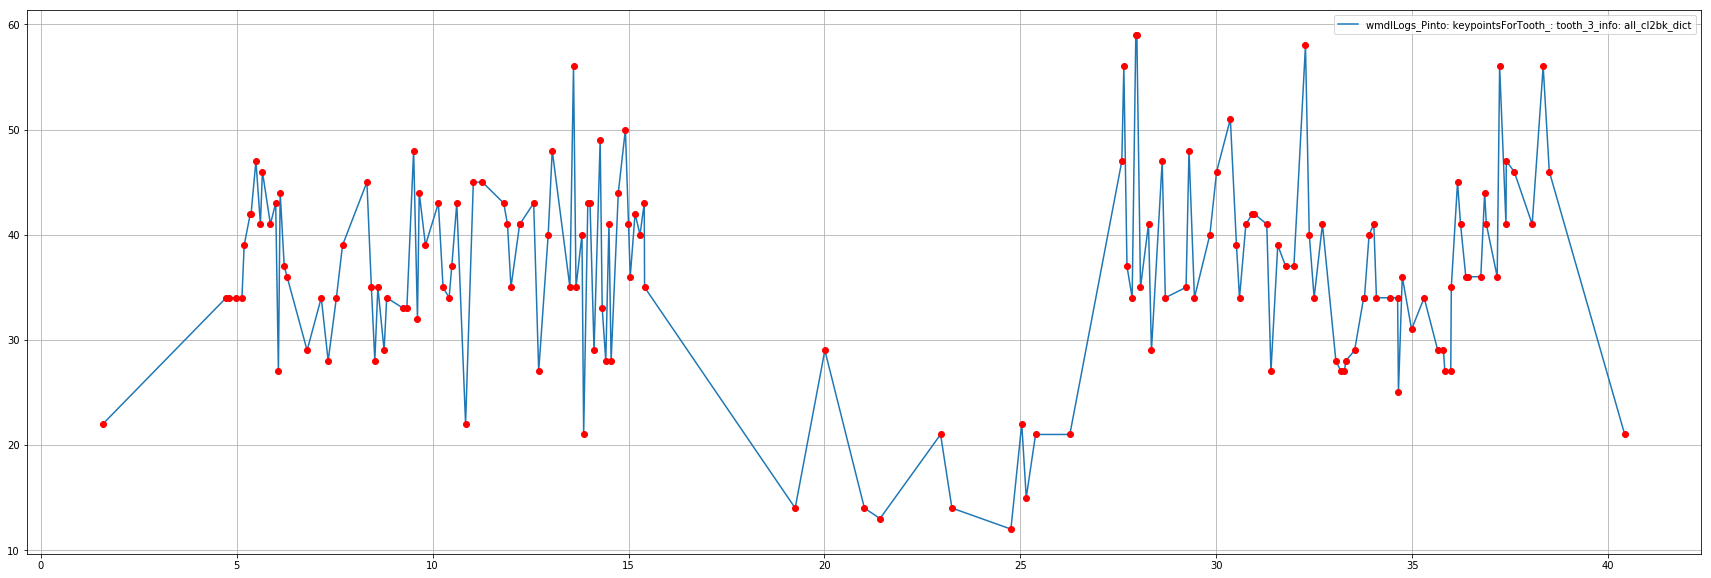


all_ls2bk_dict


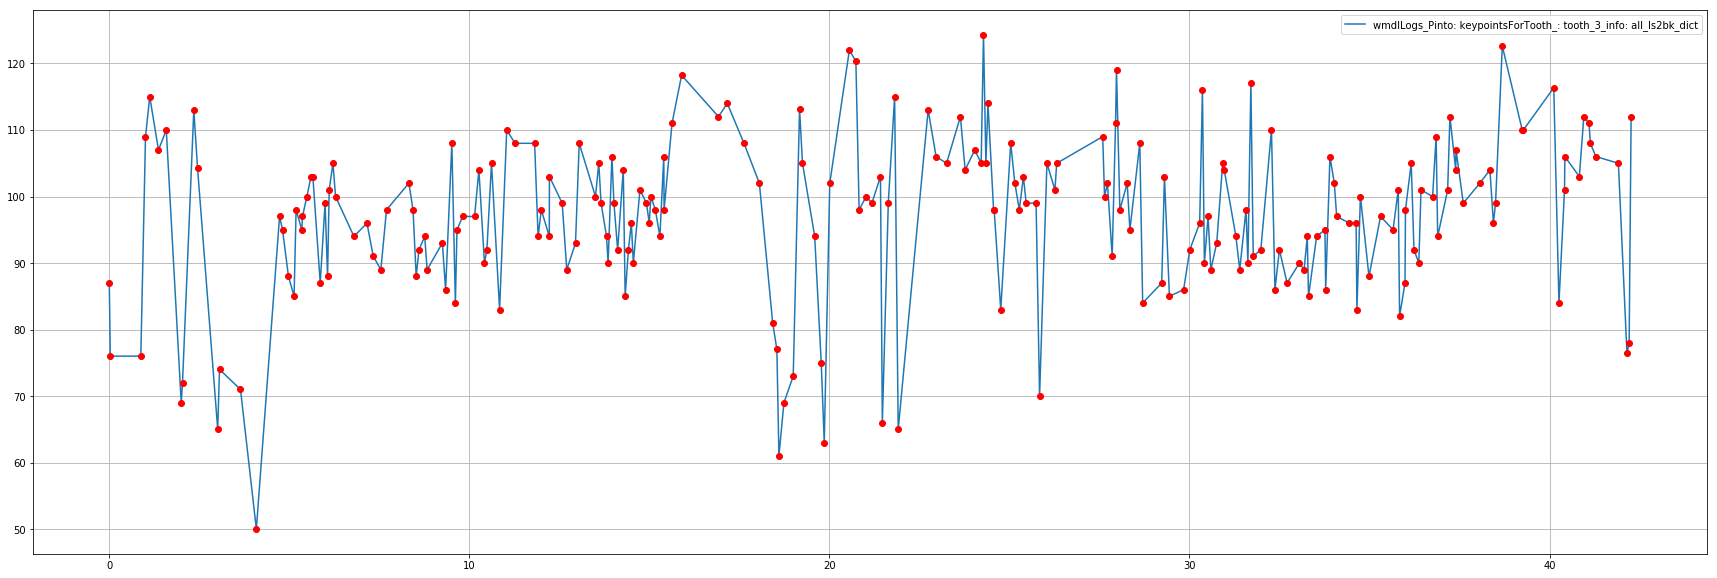


all_le2cl_dict


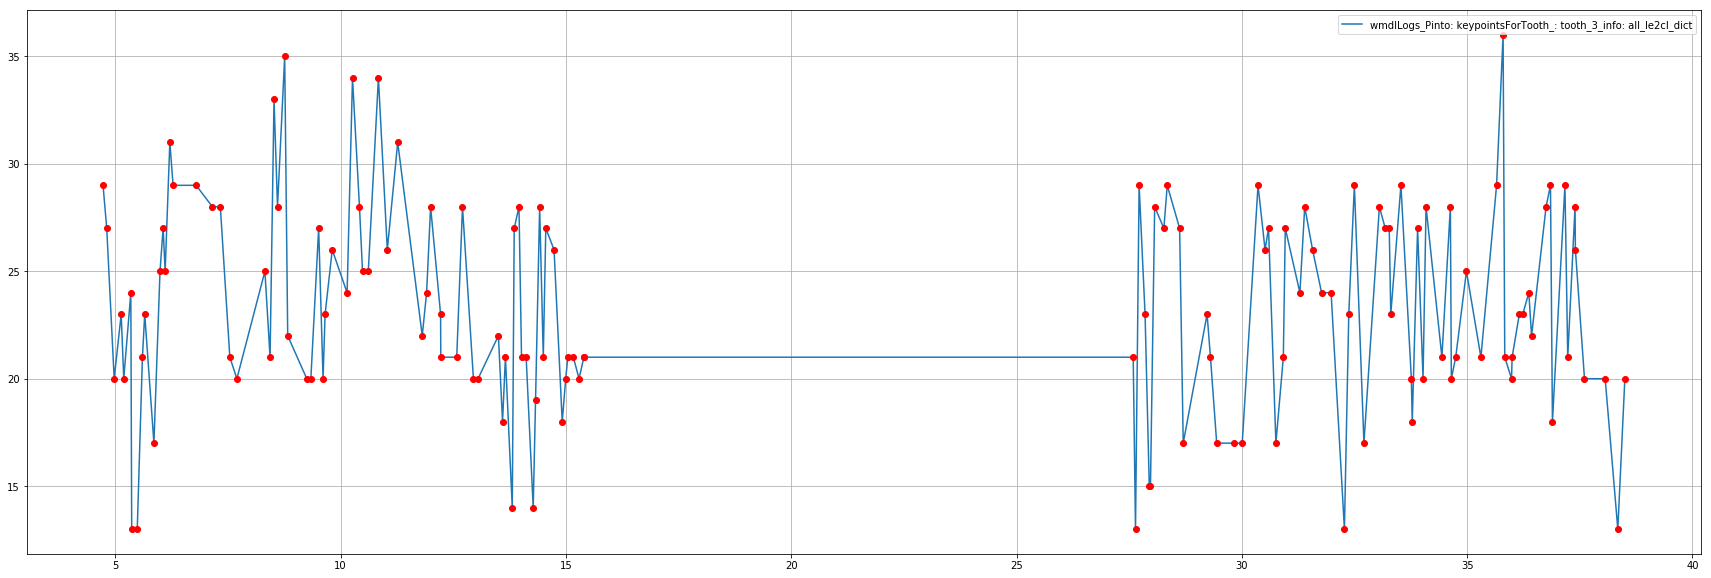


all_le2bk_dict


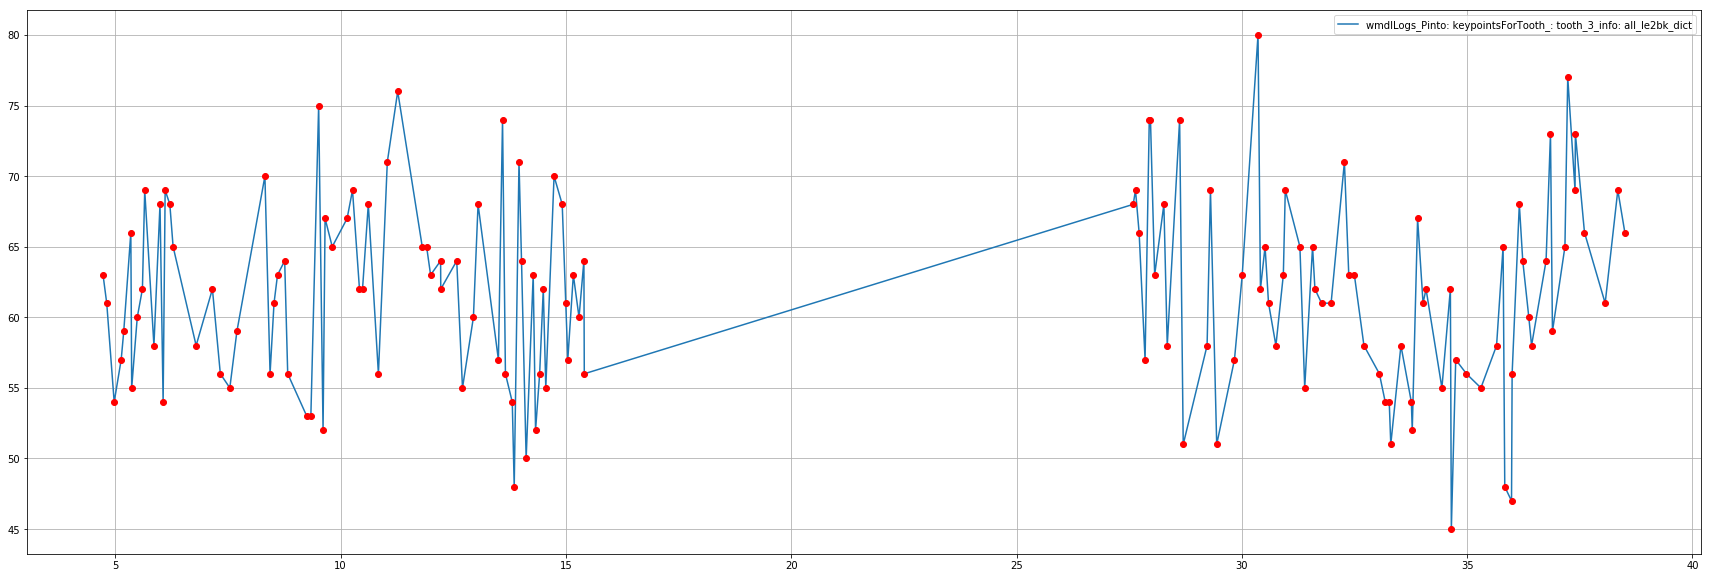


all_ls2le_dict


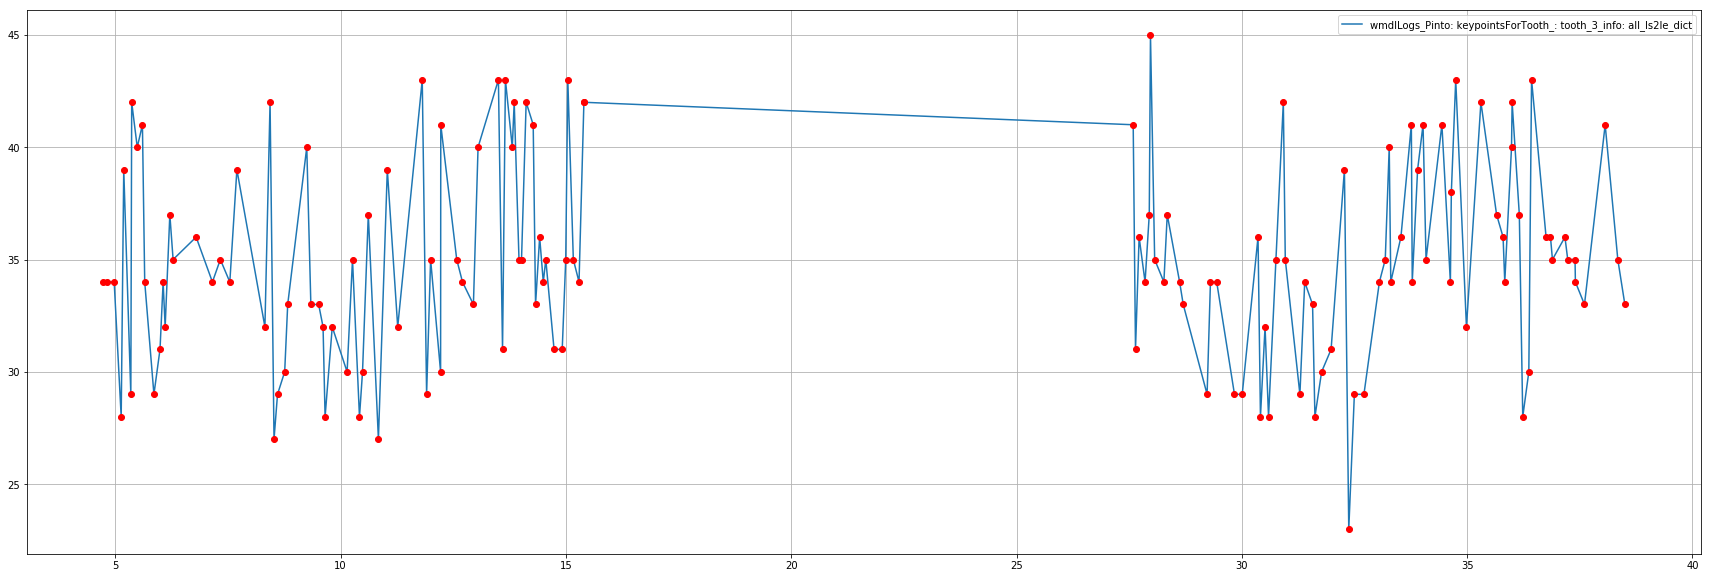


all_ls2cl_dict


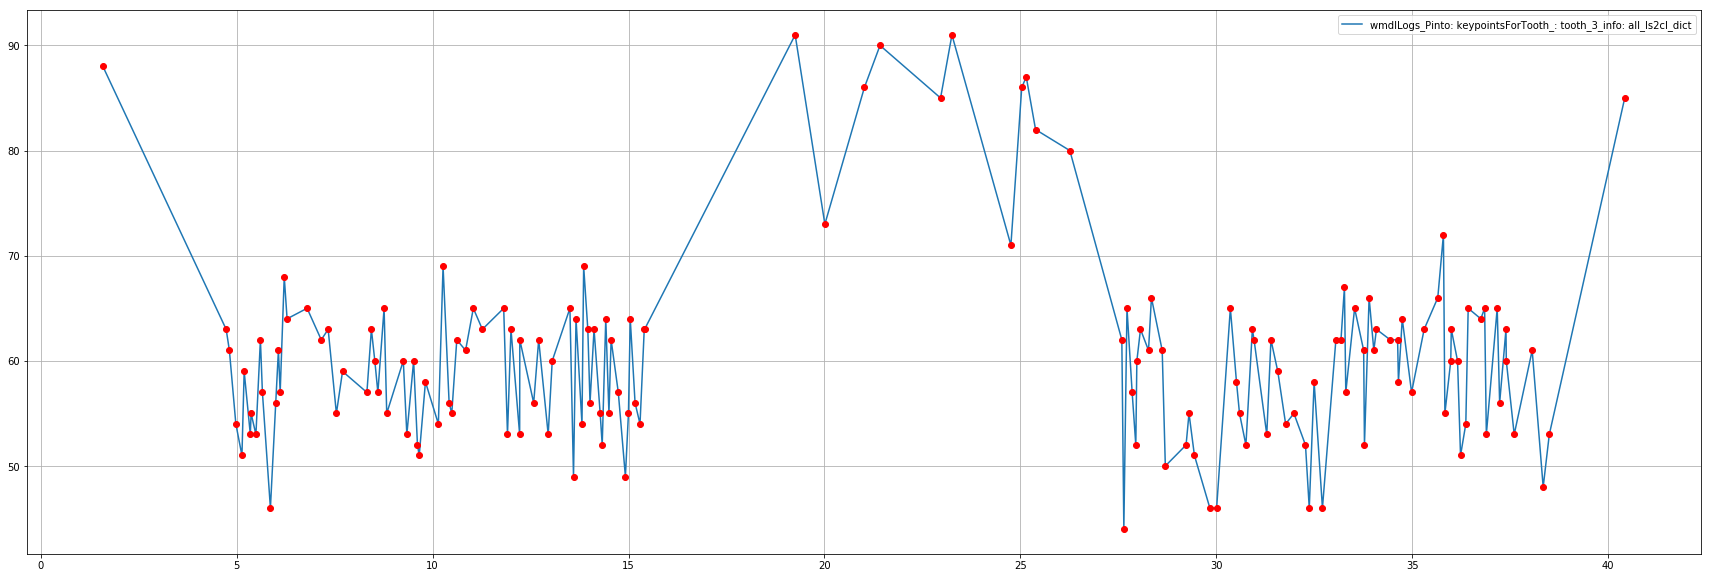


all_tt2ls_dict


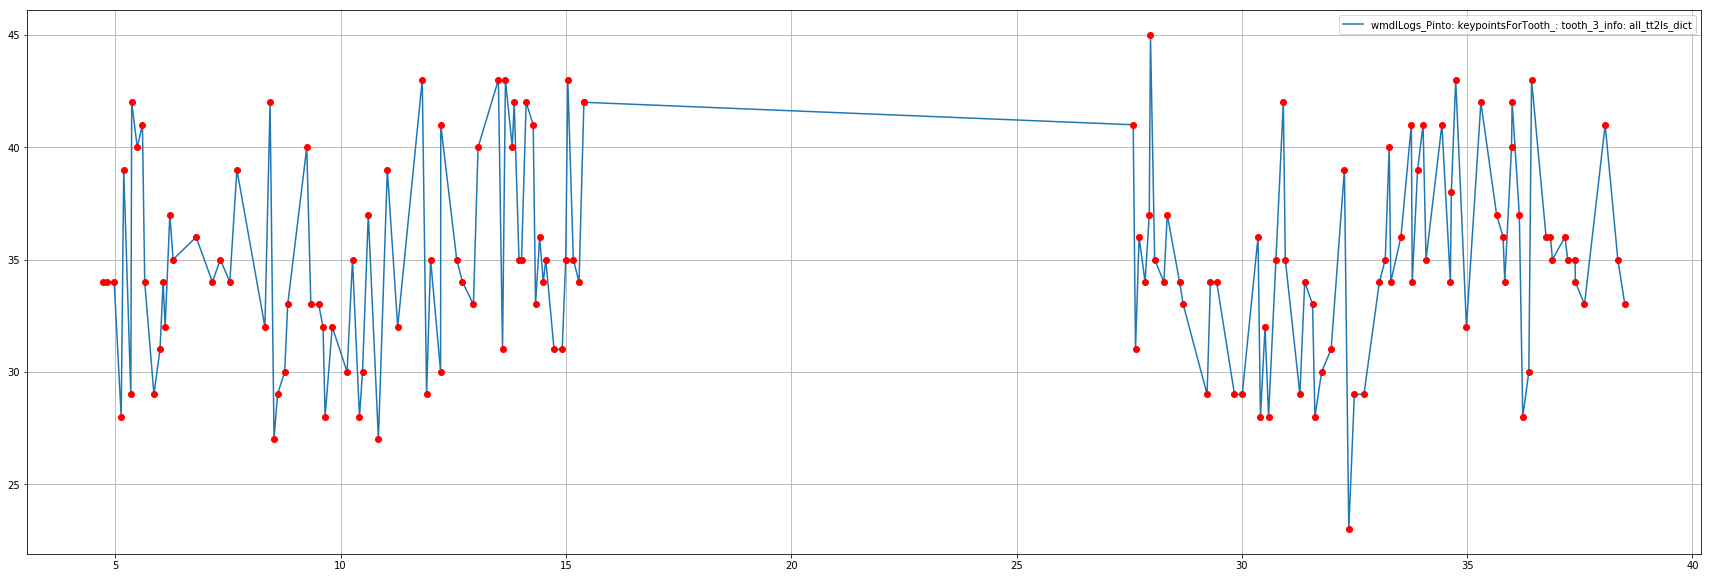

In [57]:
# all original lengths for tooth 3 Pinto Mine


all_cl2bk_dict


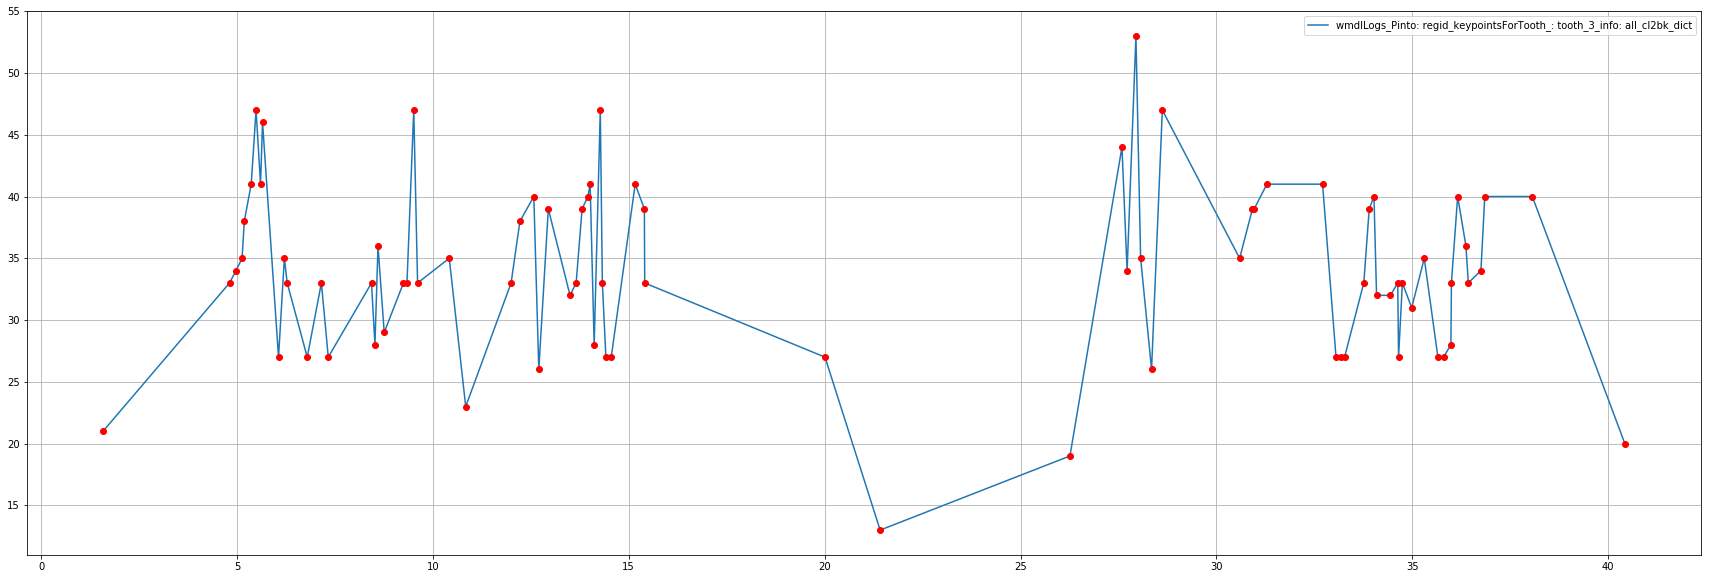


all_ls2bk_dict


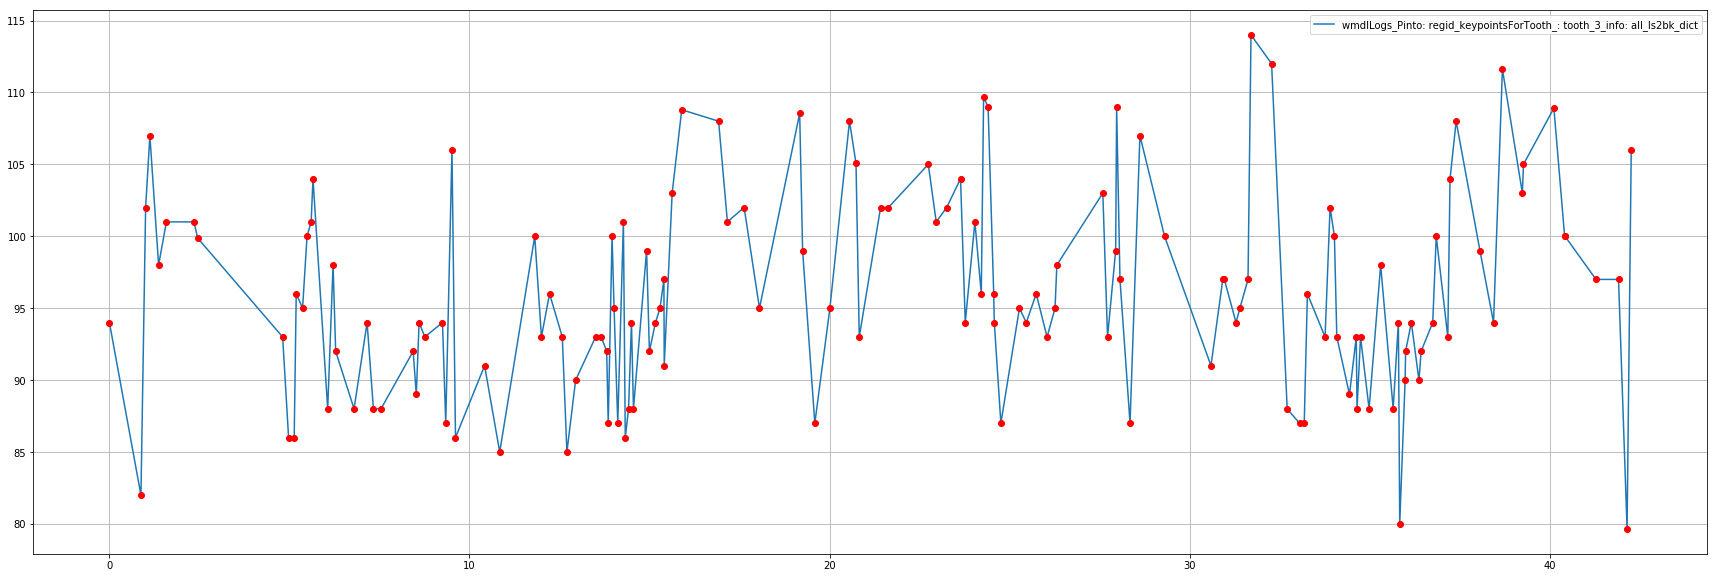


all_le2cl_dict


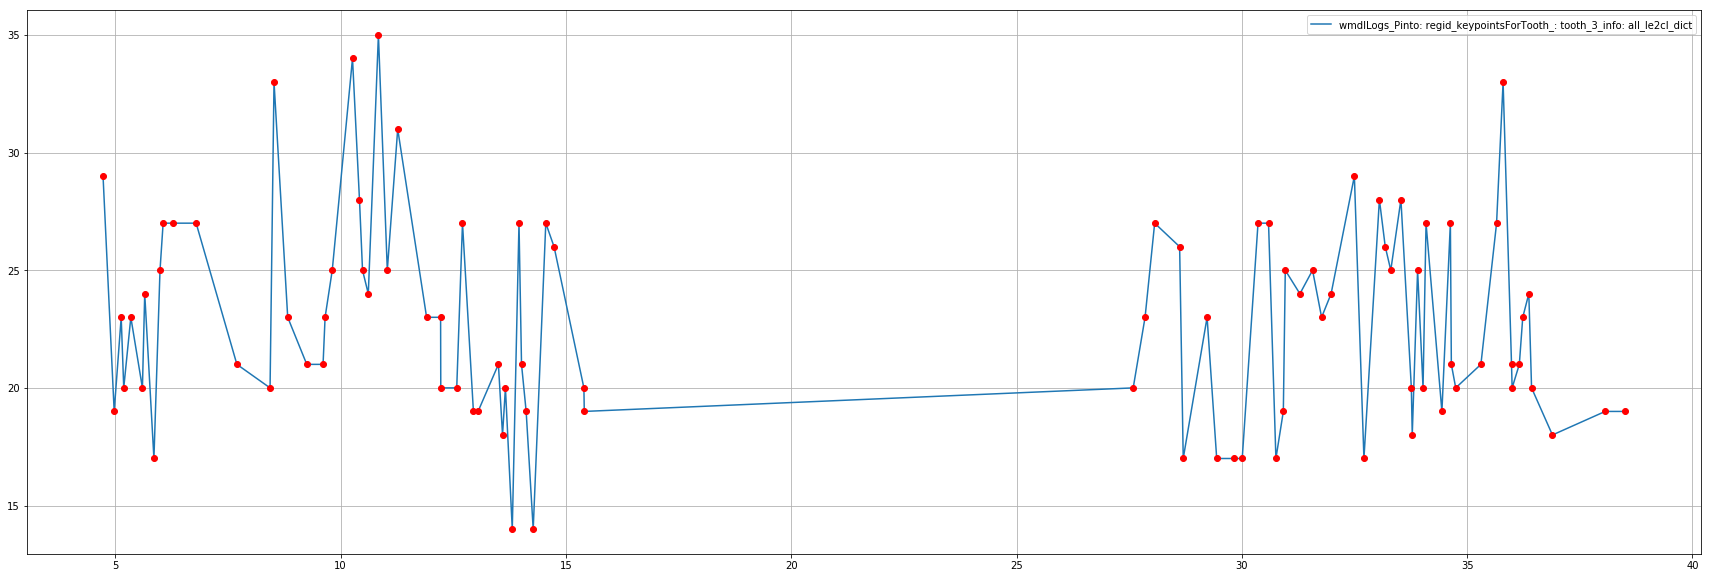


all_le2bk_dict


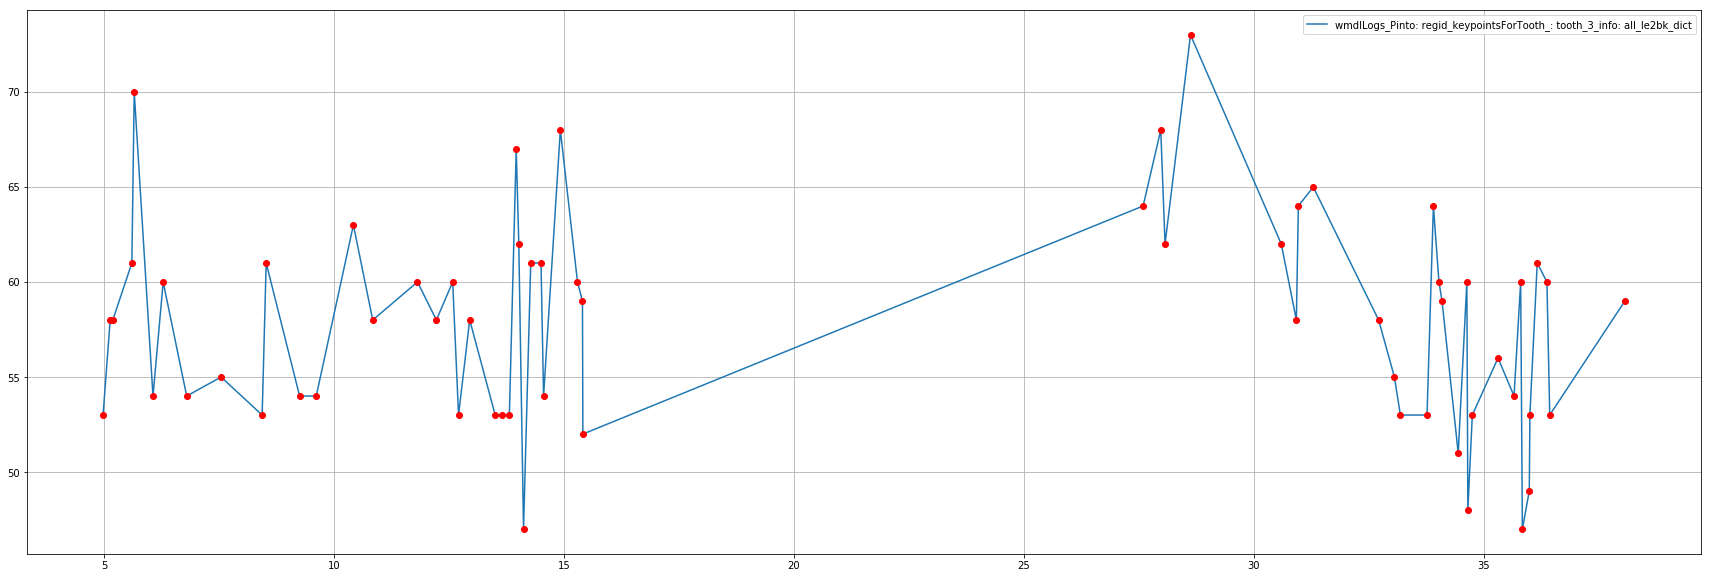


all_ls2le_dict


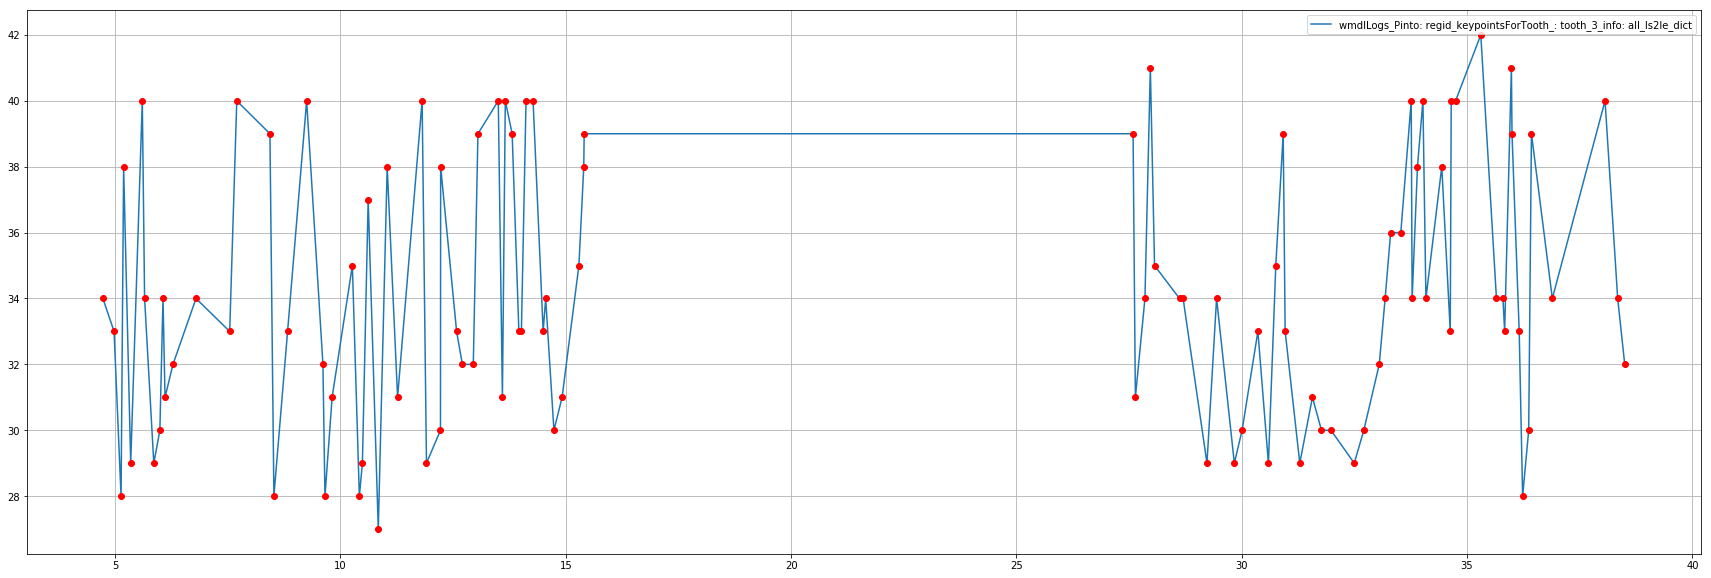


all_ls2cl_dict


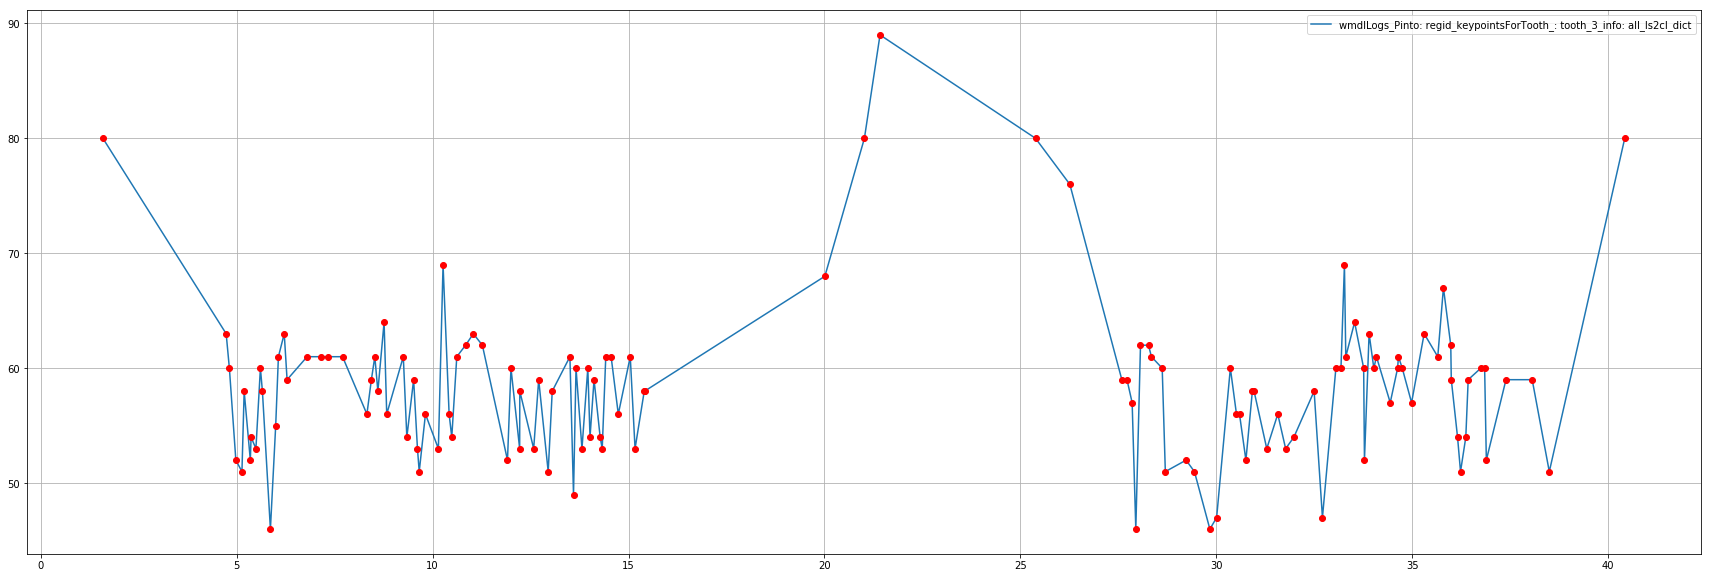


all_tt2ls_dict


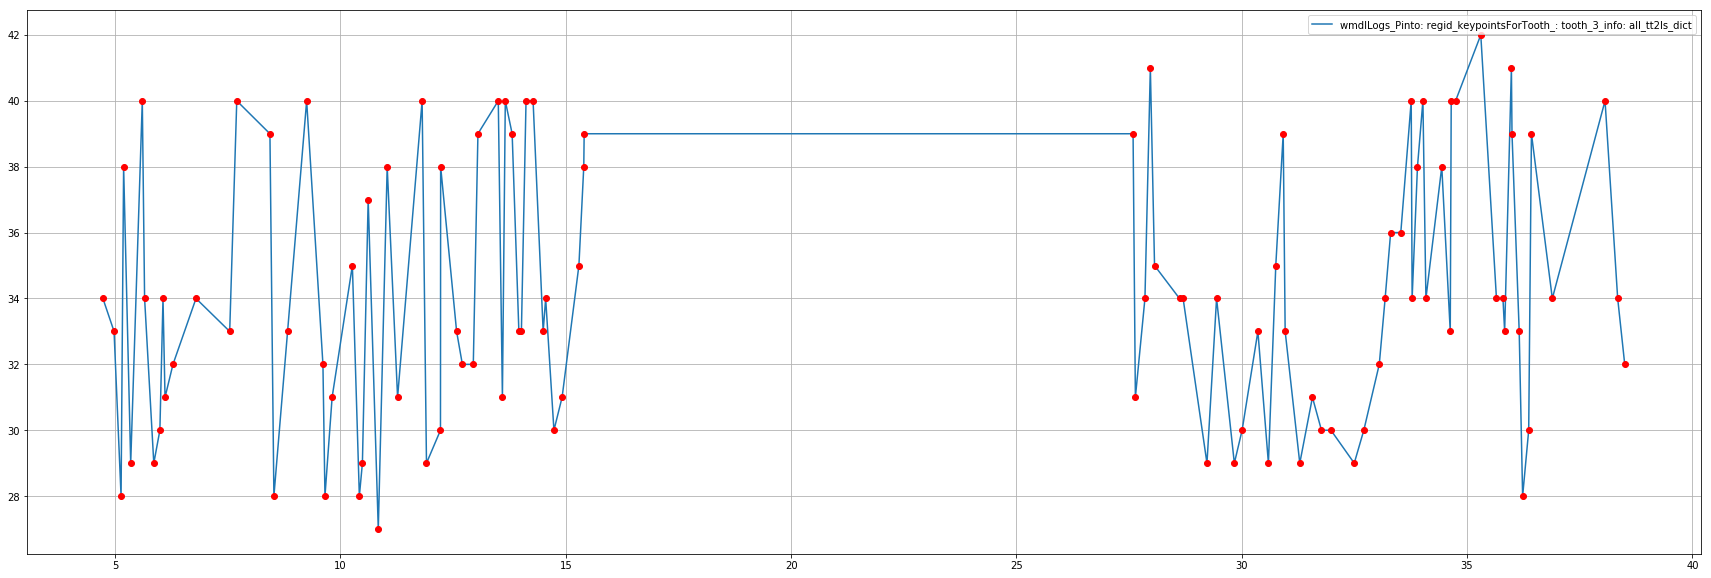

In [55]:
# all regid lengthd for tooth 3 for pinto mine


all_cl2bk_dict


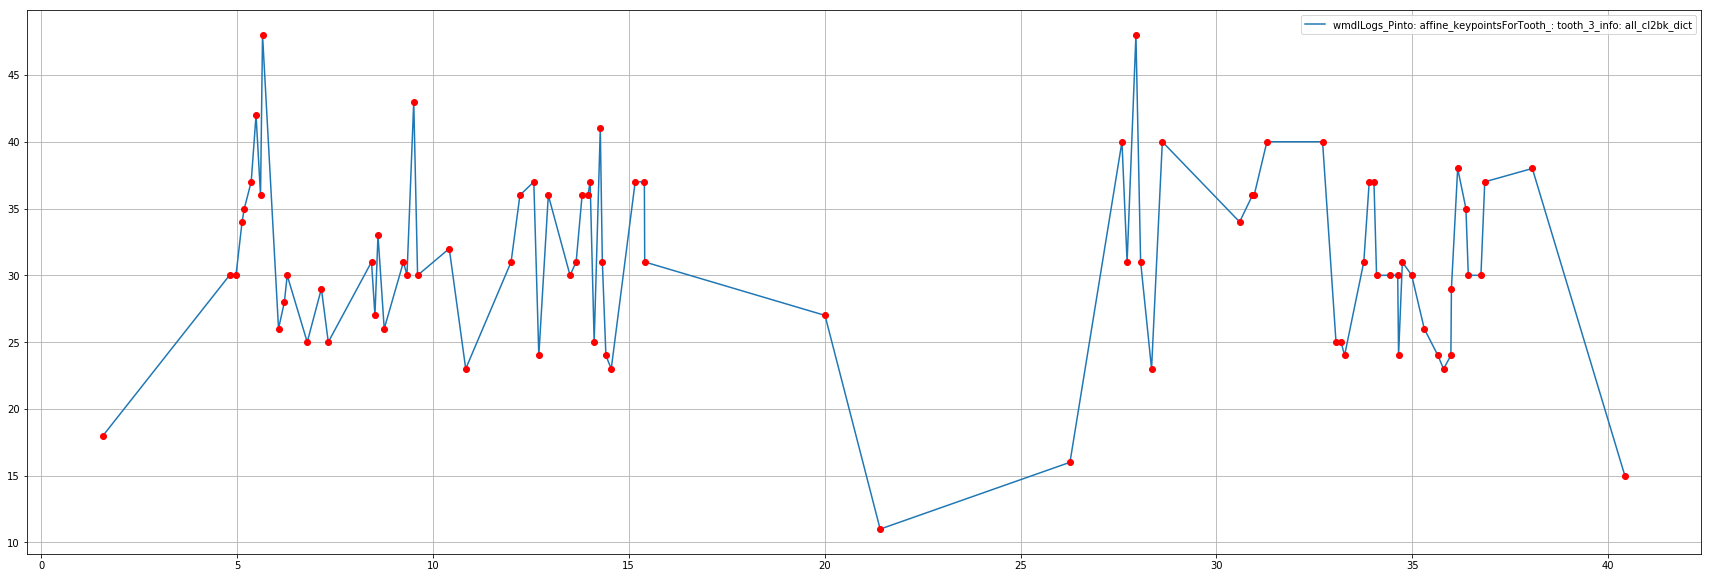


all_ls2bk_dict


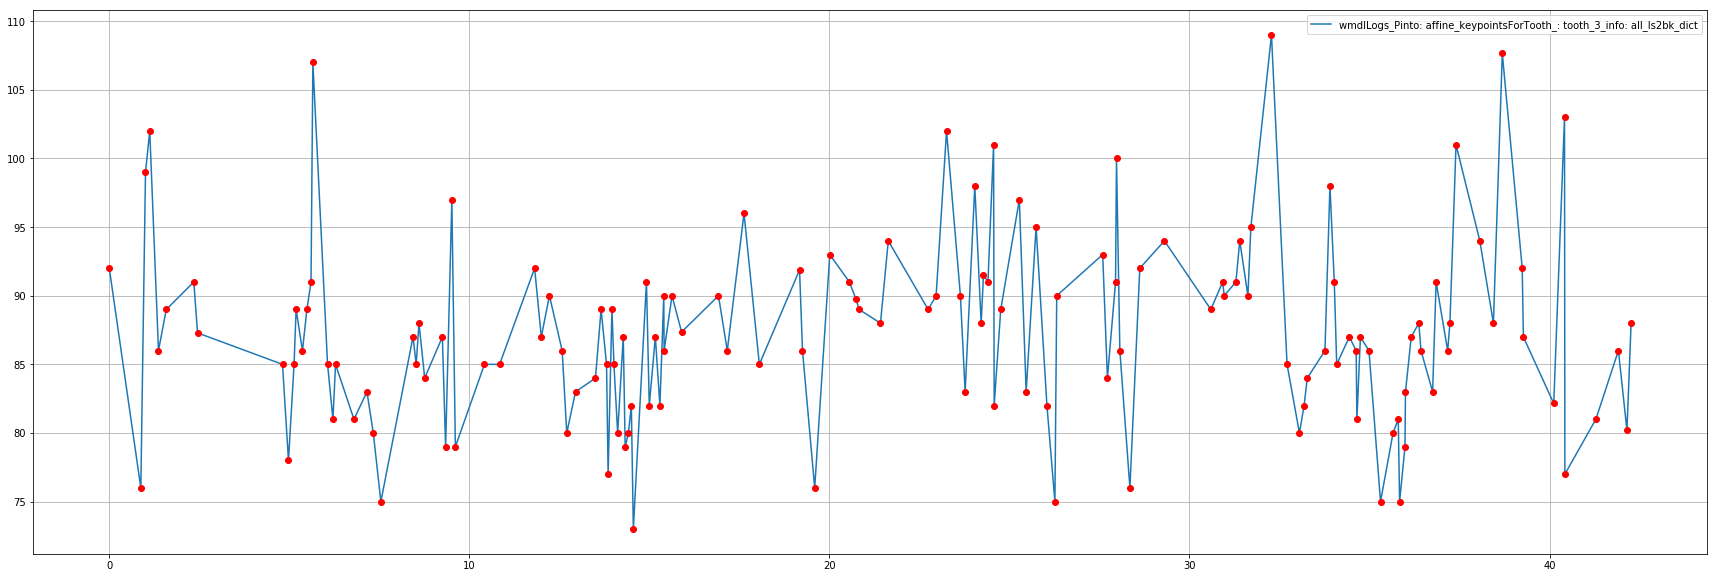


all_le2cl_dict


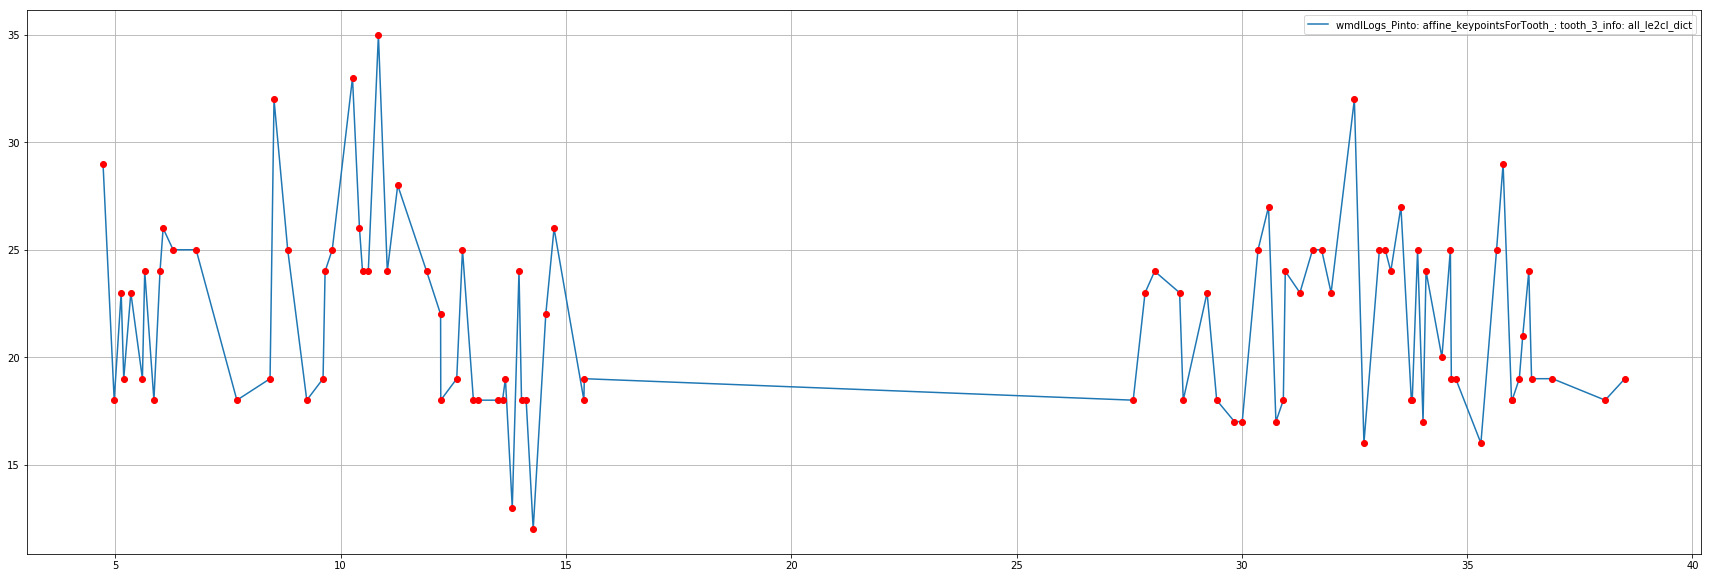


all_le2bk_dict


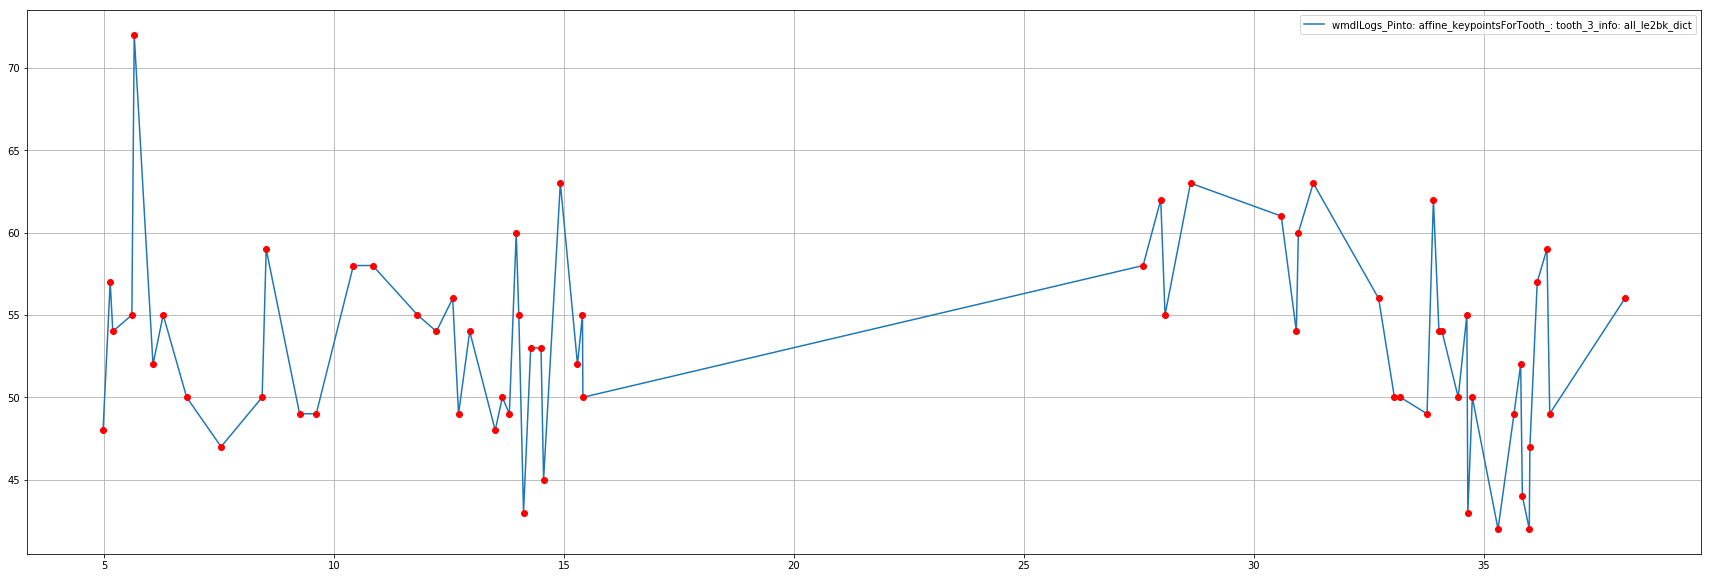


all_ls2le_dict


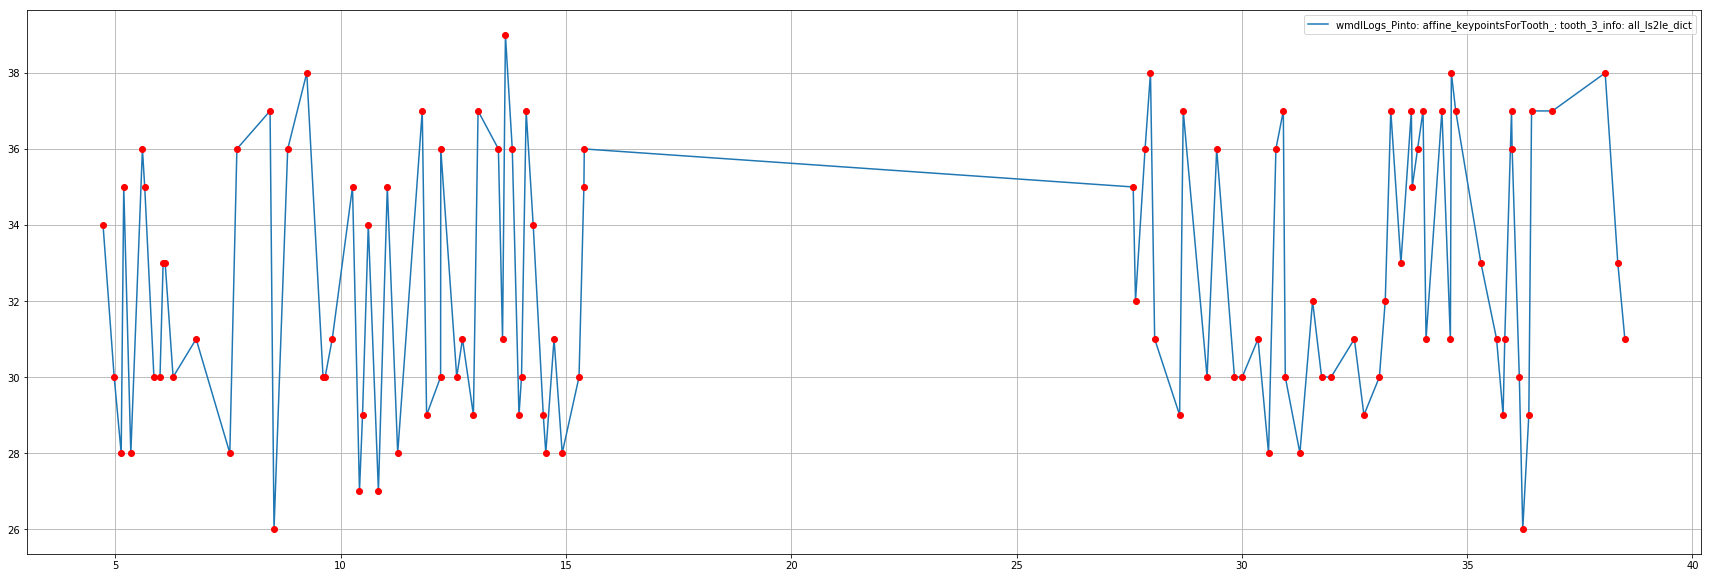


all_ls2cl_dict


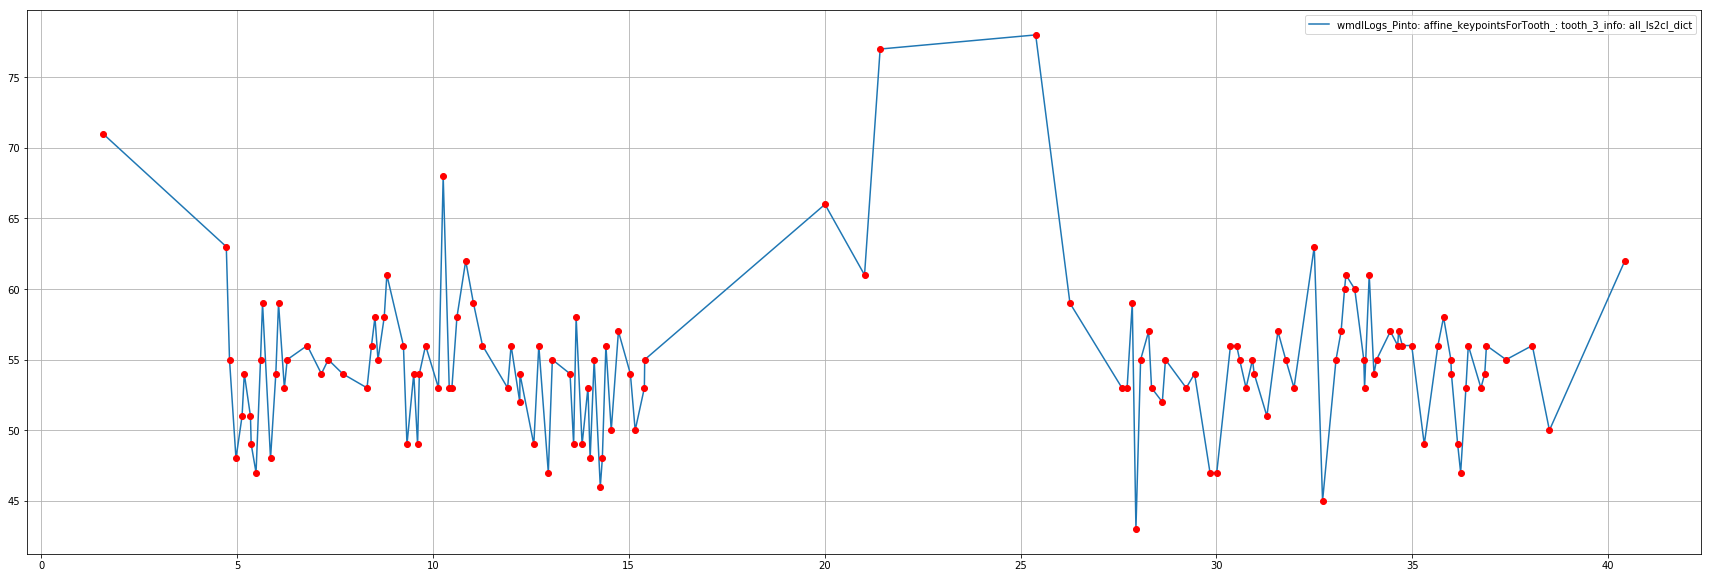


all_tt2ls_dict


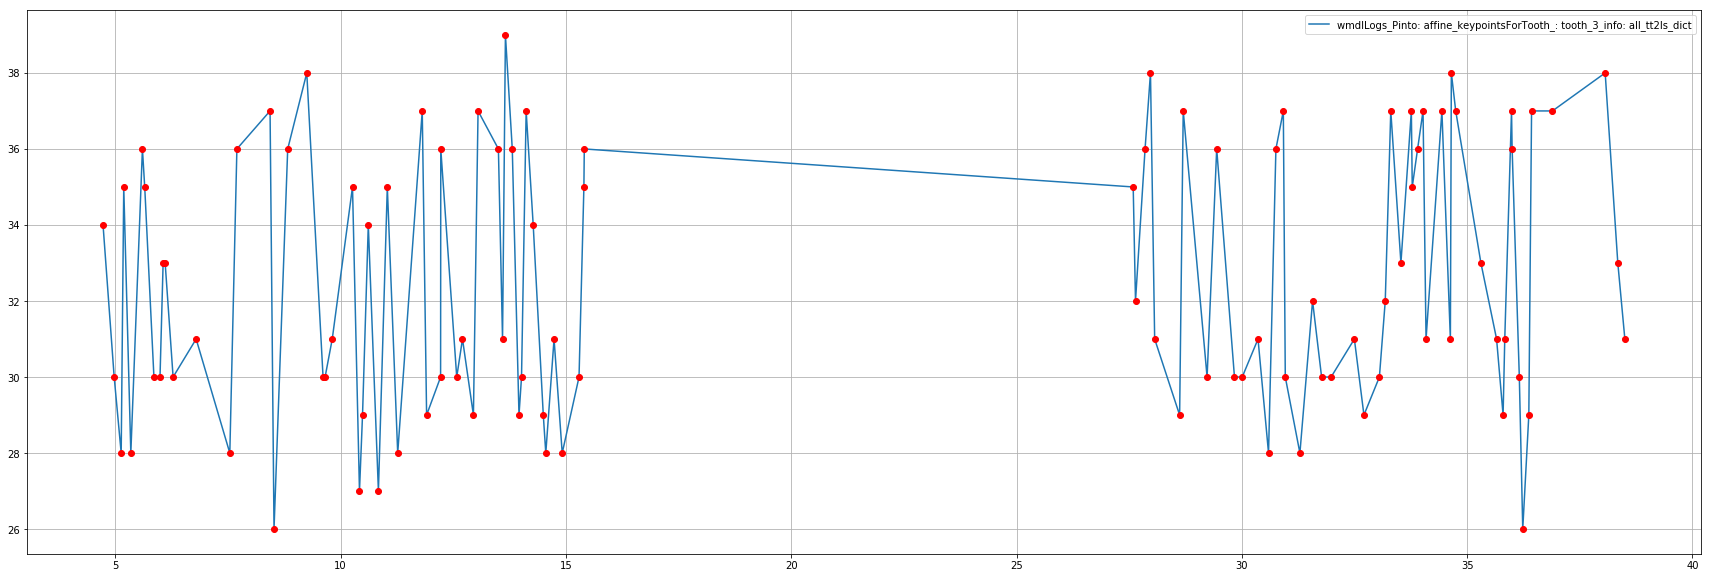

In [56]:
# all affine lengthd for tooth 3 for pinto mine

In [ ]:
# plot all original lengths for all teeth

# <font color='red'> Sandbox Area (DO NOT DELETE)

In [ ]:

resKey = 'wmdlLogs_Pinto'
time = 0
numberOfTeeth = 6
numberOfLandmarks = 5


### Unused Image2Image Registeration techniques available in OpenCV

In [ ]:
# no need for these. These take only 3 and 4 points (respectively) and solve an exact transformation (instead of an estimated one)

# Define the motion model
warp_mode = cv2.MOTION_TRANSLATION

# Specify the number of iterations.
number_of_iterations = 5000;
 
# Specify the threshold of the increment
# in the correlation coefficient between two iterations
termination_eps = 1e-10;

# Define termination criteria
criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, number_of_iterations,  termination_eps)

# Find size of image1
sz = img1.shape
 

# Define 2x3 or 3x3 matrices and initialize the matrix to identity
if warp_mode == cv2.MOTION_HOMOGRAPHY :
    warp_matrix = np.eye(3, 3, dtype=np.float32)
else :
    warp_matrix = np.eye(2, 3, dtype=np.float32)

im1_gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
im2_gray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

# Run the ECC algorithm. The results are stored in warp_matrix.
(cc, warp_matrix) = cv2.findTransformECC (im1_gray,im2_gray,warp_matrix, warp_mode, criteria)

im2_aligned = cv2.warpAffine(im2_gray, warp_matrix, (sz[1],sz[0]), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP);

plt.imshow(img1)
plt.title('img1')
plt.show()
plt.imshow(img2)
plt.title('img2')
plt.show()
plt.imshow(im2_aligned)
plt.title('im2_aligned')
plt.show()

In [ ]:
# no need for these. These take only 3 and 4 points (respectively) and solve an exact transformation (instead of an estimated one)

transformationAffine = cv2.getAffineTransform(landmarksSet1, landmarksSet2)
transformationPerspective = cv2.getPerspectiveTransform(landmarksSet1, landmarksSet2)

In [ ]:
# (Debug) single frame of above : Fit curves to landmarks and plot them for a single frame
resultsKey = 'wmdlLogs_Pinto'
imgFileName = 'WMDL_2017.10.18_22.53.03.png'
logNb = getFrameTime(filteredResultsDict, resultsKey, imgFileName)


fittC = fitCurve2keypoints(filteredResultsDict[resultsKey][logNb], 6)

inImage = cv2.imread(wmsDir + imgFileName)

outImage =  draw_all_keypoints_boxes_andCurves(inImage, filteredResultsDict[resultsKey][logNb], fittC, 6)

plt.imshow(outImage)
plt.show()

for key in fittC.keys():
    print(key)
    print(fittC[key].deriv().deriv().c[0])

In [ ]:
# calculate the second derivative of a curve. For validation.
secondDerivative = fittC['keypoints_4'].deriv().deriv().c[0]